The approach to build a **car assistant chatbot** has been described in details in the pdfs of the last two mandates. Let's have a small recap/summary of the approach:

I am working on building **a driving**
**assistance conversation agent** which takes query/command from the user regarding
different car & driving-related functionalities like inquiry about weather or navigation path,
steering assistance, using car features like Bluetooth, AC, etc., or commands like
opening/closing car windows/doors, even advanced functionality scheduling meetings, booking
tickets, etc. and by understanding the intent of the command can provide an appropriate response.

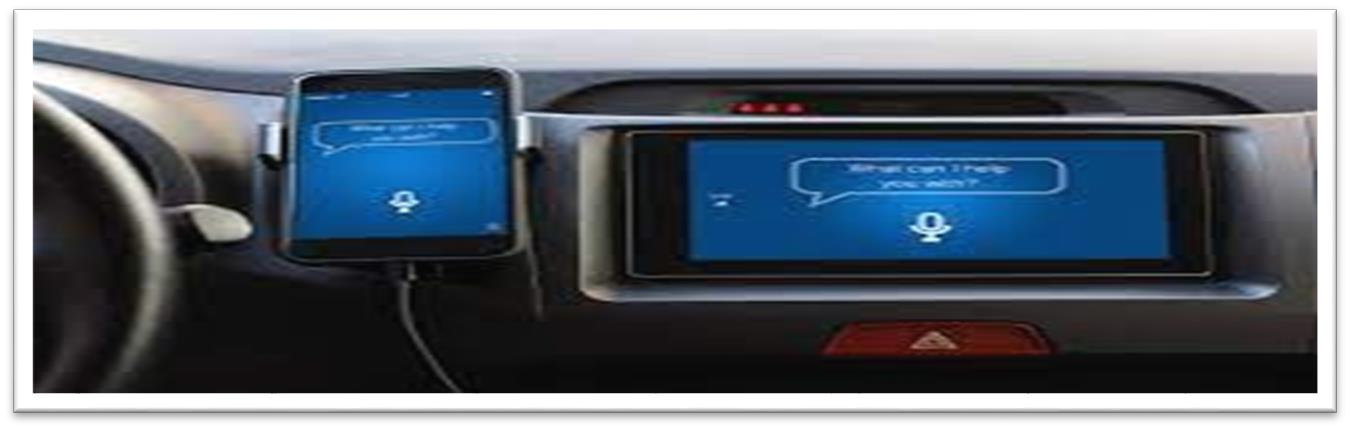
I am using **DialoGPT** which is a state-of-art pre-trained model trained to generate large-scale
responses for multi-turn conversations.

I will be using **two transformer models**- one for direct response generation and another for intent classification.
The intent of each dialog i.e, whether the query is regarding weather or navigation, etc. is also
available in the dataset. I will extract the intent data also and put it in our table as a separate
column beside their respective queries as shown in fig. Certain kinds of queries might need
live/immediate information. Like, What is the current weather in degrees at a particular place?
In such scenarios, we will also try to predict the intent of the sentence and if the intent is weather.
then we need to fetch live weather data from the internet. So, here if our model understands the
intent of the query then it can fetch that information correctly.

So, we are thinking of having two parallel training models. **Model 1** will be trained on
conversation(query-response) data and it will directly generate responses. **Model 2** will be the
intent classifier model. It will classify the intent of the query and if the intent is something that
requires live information, then that information can be fetched from online and added with the
response generated by model 1.

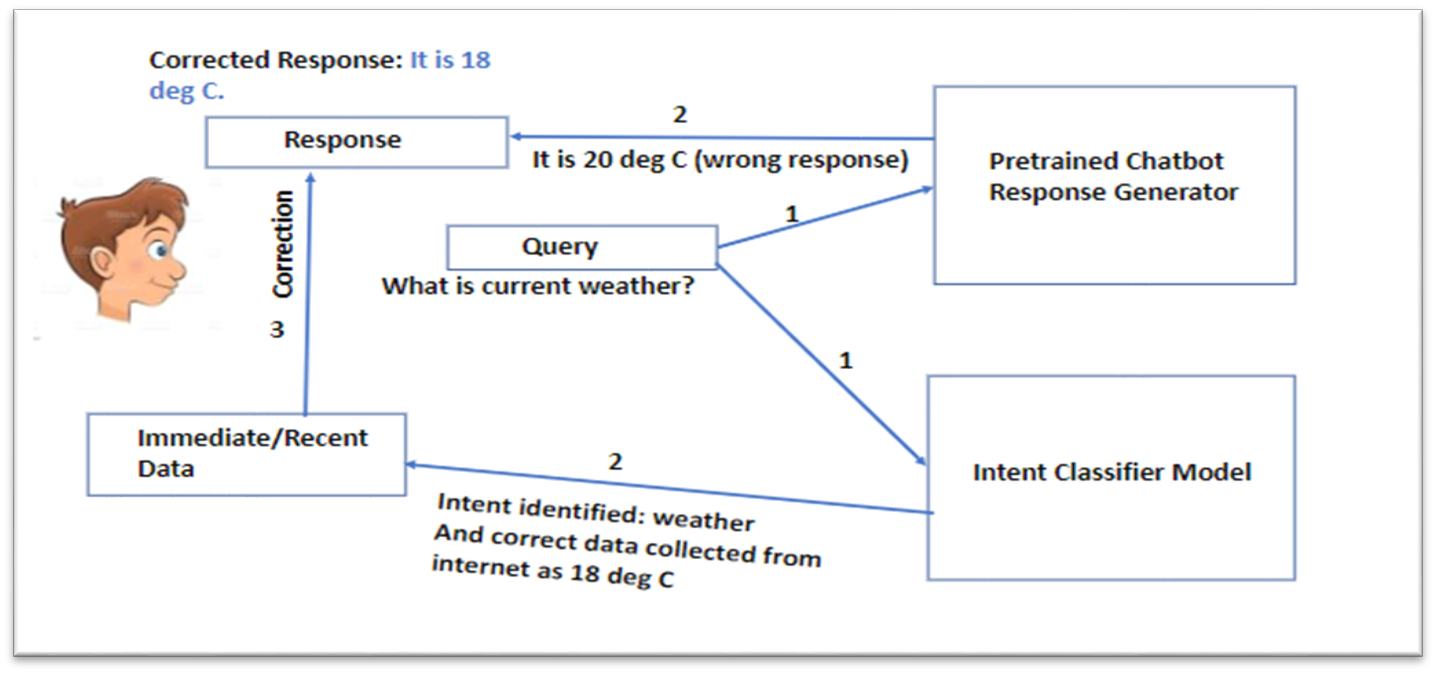

Brief Description of Above Picture:

1. Query asked by user. It goes into both models.

2. Model 1 generates a response. Model 2 classifies the intent and understands that this query
requires live data from online so it fetches the correct data.

3. Finally the wrong response generated by model 1 is corrected with the right data fetched from
online. Thus 20 deg C is changed correctly to 18 deg C.

# KVRET DataSet

Built by ***Stanford Natural Language Processing Group***([link dataset](https://nlp.stanford.edu/blog/a-new-multi-turn-multi-domain-task-oriented-dialogue-dataset/)).

This dataset is a corpus of 3031 multi-turn dialogues in 3 distinct domains and is appropriate for in-car assistant, calendar scheduling, weather information retrieval and point-of-interest navigation.

Here the conversation occurs in two modes- **Driver** & **Car Assistant**.

**Driver** asks the **Car Assistant** some query or assigns some tasks and the Car-Assistant provides with appropriate response in return.

In [ ]:
# importing required libraries
#!pip install numpy==1.20.3
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
!pip install googletrans==3.1.0a0
from googletrans import Translator
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
from nltk.util import ngrams
import random
import spacy
nlp = spacy.load("en_core_web_sm")
pd.set_option('max_colwidth', None)
nltk.download('wordnet')
nltk.download('omw-1.4')
#!pip install tensorflow
import tensorflow as tf
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language='english')
nltk.download('punkt')
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import word_tokenize
lemmatizer = nltk.stem.WordNetLemmatizer()
!pip install editdistance
import editdistance
from nltk.stem import PorterStemmer
ps = PorterStemmer()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=5f651ca8bb1662343d2a0f3aa7f51638944b6b42da74b1a6e6cb59be4e91a7ad
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip kvret_dataset_public.zip

Archive:  kvret_dataset_public.zip
  inflating: kvret_dev_public.json   
  inflating: kvret_entities.json     
  inflating: kvret_test_public.json  
  inflating: kvret_train_public.json  


As we can see our dataset .zip file contains 4 json files, among them 3 of them contains the conversation data.

In [ ]:
# Our original dataset contains conversation data along with other meta-data in .json format. We need to convert it into dataframe format with two columns-
# Query-> the user's query , Response-> the car-assistant's response


def get_dataframe(name):
  df1=pd.read_json(name)
  df_final_dataset=pd.DataFrame()
  query={}
  response={}
  intent={}
  for i in range(len(df1)):
    c=0
    for j in df1.iloc[i,0]:
      c+=1
      if j['turn']=='driver':
         query[(i,c)]=j['data']['utterance']
         intent[(i,c)]=list(list(df1.iloc[i,1].values())[1].values())[0]
      elif j['turn']=='assistant':
         response[(i,c)]=j['data']['utterance']
         intent[(i,c)]=list(list(df1.iloc[i,1].values())[1].values())[0]

  #For some queries response might not be present, so there will be length mismatch error between the query and response column of resulting dataframe if they
  # are not dealt appropriately. So the below code snippet keeps those particular queries aside in a separate python dictionary to be dealt later
  query2={}
  q_list=[]
  for q in  query:
     r=(q[0],q[1]+1)
     if r not in response:
        query2[q]=query[q]
        q_list.append(q)

  for i in q_list:
        query.pop(i)



  # Same as above code snippet only this time we consider those cases if the number of response is more than  query. Maybe the car-assistant uttered two or
  # more responses for a single query
  response2={}
  r_list=[]
  for r in  response:
     q=(r[0],r[1]-1)
     if q not in query:
        response2[r]=response[r]
        r_list.append(r)

  for i in r_list:
        response.pop(i)

  # storing the intent of the query
  intent2={}
  for j in intent:
   if j  in query:
    intent2[j]=intent[j]


  df_final_dataset2=pd.DataFrame()
  df_final_dataset2['query']=query.values()
  df_final_dataset2['response']=response.values()
  df_final_dataset2['intent']=intent2.values()


  return (intent,df_final_dataset2,query2,response2)

Just note another thing, we are also storing the intent of the query. In some of the queries like (what is current weather so here the intent is weather) we need the current value to be given to the user. So in this case we need to fetch live data from the internet.

So are also thinking have a intent classifier model too along with response generation model because if the intent classified as something that requires live data then we can add a code to fetch that data from internet.

In [ ]:
intent,df_final_dataset1,query2,response2=get_dataframe('kvret_dev_public.json')

In [ ]:
# lets see how our created dataframe looks like
df_final_dataset1.head(3)

,query,response,intent
0,make an appointment to reserve conference room 100 later this week for a meeting,What day and time should I set an appointment to reserve the conference room?,schedule
1,Monday at 3pm.,I have made an appointment for Monday at 3 pm for the meeting.,schedule
2,Is there supposed to be a blizzard in brentwood on friday?,On Friday it's gonna rain in Brentwood,weather


As we can see, our dataframe contains the query of the user and its response given by the car-assistant.

In [ ]:
print(len(query2),len(response2))

13 0


As we can  see from above result, in ***kvret_dev_public.json*** dataset, we have some extra queries with no responses.

Since the number of extra responses are not very large, we can **manually inspect them** and **curate appropriate response** for those queries.

In [ ]:
query2

{(71,
  3): 'What time and date is the meeting, and what will we be doing during the meeting?',
 (97, 3): 'That is all. Thank you!',
 (121, 5): 'That is all, thanks!',
 (134, 5): 'Okay thanks.',
 (142, 3): 'The 12th.',
 (142, 4): 'The 12th.',
 (144, 3): 'Thanks.',
 (160, 3): 'Thank you.',
 (174, 3): 'It is at 3 pm',
 (240,
  3): ' At 11 am on Sunday with the executive team to discuss the company picnic ',
 (243, 5): 'Perfect. Thank you',
 (266, 3): 'That is great, thanks.',
 (280, 3): 'at 1 pm'}

Not all the queries are relevant it seems. For eg: key **(142,3)** and key **(142,4)** has **same value**. Also, key **(144,3)** and key **(160,3)** has **same meaning**. So let's delete those responses which are **redundant**.

Then we will curate appropriate responses for remaining relevant queries and add/append them to our dataframe.

In [ ]:
# deleting redundant queries
to_delete=[(121,5),(134,5),(142,4),(144,3),(160,3),(243,5),(266,3),(174,3)]
for i in to_delete:
  query2.pop(i)

# creating appropriate responses for the remaaining
response2=["Its around PM on 3rd Feb, we will be discussing the sales growth and the target achieved by our organization this year",
           "Welcome sir",
           "Okay sir",
           "Sure sir noted.",
           "Okay sir"]

intenti=[]

for i in query2:
 if i in intent:
   intenti.append(intent[i])

# creating a dataframe with this newly created responses
df1_temp=pd.DataFrame([query2.values(),response2,intenti]).T
df1_temp.columns=['query','response','intent']

df1_temp.head()
# append the dataframe to original dataframe of kvret_dev_public.json created before
df1=pd.concat([df_final_dataset1,df1_temp],axis=0)
df1.sample(5)

,query,response,intent
606,Thanks,you are welcome,schedule
288,What is the address of Traders Joe's and give me directions with the fastesr route,The quickest route to Trader Joes is 1 mile away at 408 University Avenue.,navigate
354,Set reminder for conference at 9AM on Wednesday with infrastructure team.,Okay setting reminder for your meeting with the infrastructure team on Wednesday at 9AM.,schedule
73,car is it going to snow today,What city should I check for snow?,weather
609,Thank you.,You are welcome.,weather


Okay, so this is our final dataframe for ***kvret_dev_public.json*** file. Now let's do the same for other two.

In [ ]:
intent,df_final_dataset2,query2,response2=get_dataframe('kvret_train_public.json')

In [ ]:
print(len(query2),len(response2))

142 8


Note that this time the number of queries with responses are lot i.e, 142. We cannot manually curate so many responses!!!

But the number of responses with no queries is less(only 8) so we can create the queries for those responses.

In [ ]:
query2

{(5, 5): 'Right on, thanks. ',
 (42, 3): 'Thank you. ',
 (48, 3): 'thanks',
 (93, 3): 'Thanks.',
 (121, 3): "I'd like to set a reminder for an upcoming lab test.",
 (145, 3): 'Thank you',
 (147, 3): 'Thank you.',
 (174, 3): '11 am this month on the 12th.',
 (194, 3): 'Thank you',
 (209, 3): 'Thank you',
 (214, 3): 'Does it have the least amount of traffic?',
 (214, 4): 'Does it have the least amount of traffic?',
 (216, 3): 'The 12th at 7pm.',
 (218, 3): 'On the 29th please, at 1 pm.',
 (240, 3): 'I need it for Seattle.',
 (254, 5): 'Thank you',
 (255, 3): 'today at 3 pm',
 (281, 3): 'Okay perfect! Thank you.',
 (282, 3): 'The meeting is on December 12th with HR at 11am.',
 (289, 3): 'Set it for Friday. ',
 (297, 3): 'Thank you',
 (299, 3): 'Thanks',
 (329, 1): 'can i get the two day weather report',
 (353, 3): 'Thanks',
 (356, 5): 'Schedule for 10 am please.',
 (358, 3): 'Thank you',
 (384, 3): 'You have told me what I needed, thank you.',
 (409, 3): 'do i have a swimming activity sch

As discussed since we cannot create all the 142 responses manually, what we are doing in below code is that we are first observing what are the common queries asked in the 142 queries.  Then we will curate a handful of answers manually and map queries to their appropriate response.

In [ ]:
responses_q=['Sir, can you repeat please?',"Sure, sir!!",'Sure sire I will schedule.','Welcome sir!!']

indis={(121,3),(174,3),(218,3),(255,3),(282,3),(289,3),(356,5),(409,3),(516,1),(669,3),(676,3),(999,3),(1143,3),(1144,3),(1146,3),(1154,3),\
      (1206,3),(1363,3),(1823,3),(1842,3),(2171,3),(2192,3),(2288,3),(2346,3),(2414,3) }

response_ac=[]
import random
for i in query2:
  if i in indis:
    response_ac.append(responses_q[2])
  elif i not in indis and 'thank' in query2[i].lower() and len(query2[i].split(' '))<5:
    response_ac.append(responses_q[3])
  else:
    choice_of_response2=random.choices(responses_q[0:2], weights=[0.2,0.8], k=1)
    response_ac.append(choice_of_response2[0])


intenti=[]

for i in query2:
 if i in intent:
   intenti.append(intent[i])

df2_temp=pd.DataFrame([query2.values(),response_ac,intenti]).T
df2_temp.columns=['query','response','intent']


# append the dataframe to original dataframe of kvret_dev_public.json created before
df2=pd.concat([df_final_dataset2,df2_temp],axis=0)
df2.sample(5)

,query,response,intent
6123,direct me to the nearest starbucks,"There is no Starbucks nearby, but Palo Alto Cafe is 2 miles away. Would you like directions there?",navigate
4192,Set a reminder for dentist appointment at 5 pm on the 2nd with Ana.,"Okay, scheduling a dentist appointment with Ana for the 2nd at 5pm.",schedule
348,Find a parking garage.,There is 2 local parking garage's; both are 3 miles away. Palo Alto Garage has moderate traffic and Stanford Oval has no traffic. Which one do you prefer?,navigate
3258,Thank you very much car!,"You're welcome, I'm here to assist you!",navigate
1744,Thanks!,No problem.,schedule


In [ ]:
len(query2)

142

In [ ]:
response2

{(687, 3): 'What city would you like to know if it is going to rain in?',
 (687, 4): "In which city do you want to know if it's going to rain?",
 (824, 5): 'There is very high chance of rain in Carson next week.',
 (824, 6): 'There is very high chance of rain in Carson next week.',
 (1404,
  3): "Topanga Mall is the nearest shopping mall and it's located 8 miles away.",
 (1404,
  4): 'Topanga Mall is the nearest shopping mall. Setting GPS for fastest route.',
 (2179, 5): 'Taking you to Cafe Venetia.',
 (2179, 6): "you're welcome"}

In [ ]:
to_delete=[(687,4),(824,5),(1404,3),(2179,6)]
for i in to_delete:
  response2.pop(i)


intenti=[]

for i in response2:
 if i in intent:
   intenti.append(intent[i])

query2_={"Can you tell if it's raining?",
         "Carson, is it raining there?",
         "Can you please tell me what is the nearest shopping mall from here?",
         "Where are we going now?"}

df2_temp=pd.DataFrame([query2_,response2.values(),intenti]).T
df2_temp.columns=['query','response','intent']

df2=pd.concat([df_final_dataset2,df2_temp],axis=0)
df2.sample(3)

,query,response,intent
3111,"Where is the meeting and when is it, also who is attending?","For which one? I have you listed for two, one in conference room 100 at 11 am on the 20th with executive team, and one in conference room 50 at 3pm on Tuesday with HR.",schedule
2836,The whole week.,"In Inglewood, it will be overcast Monday, frost on Tuesday, clear on Wednesday, raining on Thursday, dry on Friday, misty on Saturday, clear on Sunday.",weather
2163,Thanks.,You are welcome.,schedule


In [ ]:
intent,df_final_dataset3,query2,response2=get_dataframe('kvret_test_public.json')

In [ ]:
print(len(query2),len(response2))

13 0


In [ ]:
query2

{(11, 3): 'Thank you',
 (26, 7): 'Very good, thank you.',
 (42, 5): 'Thank you.',
 (115, 3): 'Thank you!',
 (133, 3): 'I want to go swimming at 10 am, next month on the 12th.',
 (148, 3): 'Thank you',
 (162, 3): 'Thank you very much!',
 (211, 3): 'Thank you kindly.',
 (236, 3): 'Does Stanford Express Care have heavy traffic nearby?',
 (236, 4): 'Does Stanford Express Care have heavy traffic nearby?',
 (247, 3): 'Thank you.',
 (269, 3): 'Thanks a lot. ',
 (281, 5): 'Great.'}

  Here, only two queries seem important- **(133,3)** and **(236,4)**

In [ ]:
to_retain=[(133,3),(236,4)]
query3={}
for i in query2:
  if i in to_retain:
     print(i)
     query3.update({i:query2[i]})

response2={"Okay sir, will take you to ABC Swimming Club next month.",
           "Yes, this week there will be heavy traffic at Stanford Express Care"}

intenti=[]

for i in response2:
 if i in intent:
   intenti.append(intent[i])

df3_temp=pd.DataFrame([query3.values(),response2,intenti]).T
df3_temp.columns=['query','response','intent']

#response2={"Okay sir, will take you to ABC Swimming Club next month.",
         #  "Yes, this week there will be heavy traffic at Stanford Express Care"}




df3=pd.concat([df_final_dataset3,df3_temp],axis=0)
df3.sample(3)

(133, 3)
(236, 4)


,query,response,intent
8,And the temperature?,It will be between 20-30F in Alhambra on Friday.,weather
789,What is the address?,269 Alger Dr is the location of Cafe Venetia.,navigate
691,"Manhattan, please. Will it be cloudy on Monday?","Monday will be foggy, with low's of 30F and high's of 40F. Similar heh.",weather


# ENGLISH AUTOMOBILE CABIN COMMANDS CORPUS Language Dataset

Contributed by native European and American English speakers with driving experience, the [dataset](https://magichub.com/datasets/english-automobile-cabin-command-text-corpus/) currently has 500 sentences*(trial version)*, including the intention of closing and opening common components inside and outside the vehicle, such as opening/closing the door, altering the side view mirror, steering wheel control, etc.

Also, expressions of the cabin function points in diverse forms are included as well, i.e., panoramic camera=omnidirectional camera=full view camera.

In [ ]:
!unzip 'English Automobile Cabin Command Text Corpus.zip'

Archive:  English Automobile Cabin Command Text Corpus.zip
  inflating: MDT-NLP-B007.txt        
  inflating: README.txt              


In [ ]:
df_cabin=pd.read_csv('MDT-NLP-B007.txt',sep='\t')
df_cabin.head()

,领域,中文产品集,参考句&泛化句,分类复标
0,车控,打开,close 50% left door,Do
1,车控,打开,close 50% left flap door,Do
2,车控,打开,close 50% left Lambo door,Do
3,车控,打开,close 50% left Lamborghini door,Do
4,车控,打开,close 50% left scissor door,Do


As we can see, some text aas well as the column names are in **Chinese** language. Need to convert them to **English**.

In [ ]:
# Converting column names to English
from googletrans import Translator

translator = Translator()

cols=[]

for j in df_cabin.columns:
    cols.append(translator.translate(text=j,src='zh-cn').text)

df_cabin.columns=cols

In [ ]:
# As indicated from above pic the forst two cols only have data in Chinese, so need to convert them to English
col_to_chg=[0,1]
for i in range(len(df_cabin)):
  for j in col_to_chg:
    df_cabin.iloc[i,j]=translator.translate(text=df_cabin.iloc[i,j],src='zh-cn').text

In [ ]:
df_cabin.head()

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling
0,car control,Open,close 50% left door,Do
1,car control,Open,close 50% left flap door,Do
2,car control,Open,close 50% left Lambo door,Do
3,car control,Open,close 50% left Lamborghini door,Do
4,car control,Open,close 50% left scissor door,Do


In [ ]:
df_cabin['field'].unique()

array(['car control', 'system settings', 'Camera'], dtype=object)

As seen from the queries in this dataset are categorized into 3 categories-car control , system settings and Camera. These can also be understood as the intent of the query.

In [ ]:
#df_cabin_c=df_cabin.copy()

As we can see above, our dataset contains queries/command divided into 3 categories- **car control** , **system settings** and **Camera**.

We will try to get a hint of the content of each category using **WordClouds** - but instead of using single word in our wordcloud, we will use **bigrams** for better sense of them.
eg: **close_window** makes better sense than just **window**.

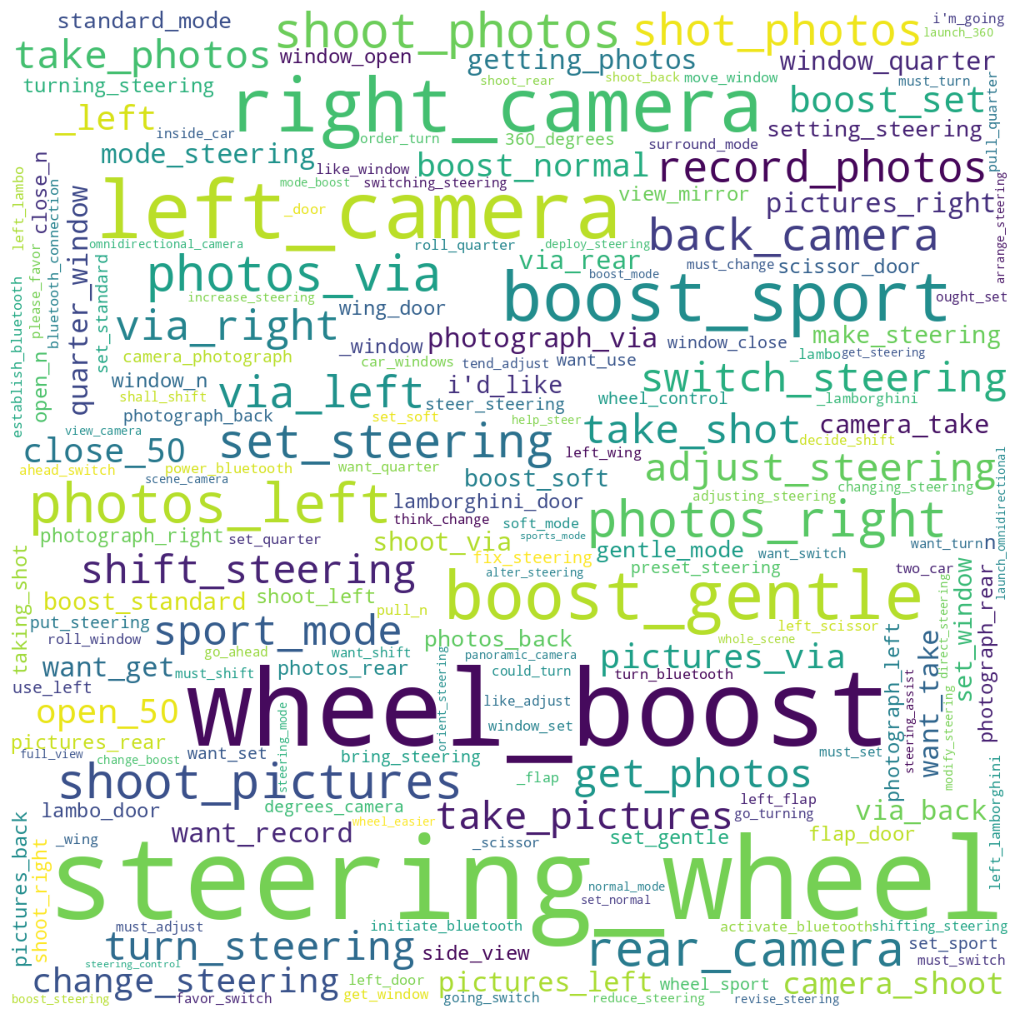

In [ ]:
df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].str.lower()
df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 1, i.split())))
df_cabin_c=df_cabin.copy()
df_cabin['bigram']=df_cabin['Reference Sentence & Generalization Sentence'].apply(lambda row: list(nltk.bigrams(row.split(' '))))

text_all=''
for i in range(len(df_cabin)):
  list_all=df_cabin.iloc[i,-1]
  for i in list_all:
     i2=i[0]+'_'+i[1]
     text_all=text_all+' '+i2

wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                min_font_size = 12,collocations=False).generate(text_all)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

We can see from the wordcloud the topics which are mostly inquired to the car-assistant as queries in our dataset include- about **steering wheel, change steering, boost_sport, boost_gentle** etc i.e, different driving operation commands

also we can see bigrams like- **record_photo,back_cameras, take_photo, left_camera** etc. indicating user asking the car-assistant to adjust camera and take photos.

we also can see words like **windows** in different combinations- indicating the user is giving commands on window maybe opening/closing them etc,

Note that in this dataset we only have the queries, but we also need the corresponding responses in order to train them. So we will generate proper responses of the queries by proper inspection of the query data.

# Camera

In [ ]:
df_cabin[df_cabin['field']=='Camera'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram
483,Camera,Camera on the right,get photos right camera,Do,"[(get, photos), (photos, right), (right, camera)]"
433,Camera,Camera on the right,photograph via right camera,Do,"[(photograph, via), (via, right), (right, camera)]"
162,Camera,rear camera,photograph via rear camera,Do,"[(photograph, via), (via, rear), (rear, camera)]"
399,Camera,Camera on the left,get photos via left camera,Do,"[(get, photos), (photos, via), (via, left), (left, camera)]"
495,Camera,Camera on the right,want get photos right camera,Sentence,"[(want, get), (get, photos), (photos, right), (right, camera)]"
185,Camera,rear camera,shoot photos via back camera,Do,"[(shoot, photos), (photos, via), (via, back), (back, camera)]"
487,Camera,Camera on the right,want record photos right camera,Sentence,"[(want, record), (record, photos), (photos, right), (right, camera)]"
414,Camera,Camera on the left,want use left camera get photos,Sentence,"[(want, use), (use, left), (left, camera), (camera, get), (get, photos)]"
234,Camera,Camera on the left,take photos via left camera,Do,"[(take, photos), (photos, via), (via, left), (left, camera)]"
474,Camera,Camera on the right,record photos right camera,Do,"[(record, photos), (photos, right), (right, camera)]"


After seeing many samples of the data for field Camera, we can understand that majority of the queries/commands are to ask the car assistant to click photograph via different cameras.

The **Chinese product set** column contains the name & position of the camera. So we can create response with a simple trick- we can just add some prefix in beginning of the column content.

So if the **Chinese product set** for a row is - camera on the left, the we can create response:

*Sure sir I am clicking photo via* + *camera on the left*= ***Sure sir I am clicking photo via camera on the left***

Similarly,
*Sure sir I am clicking photo via* + *rear camera*= ***Sure sir I am clicking photo via rear camera***



To add variety of response and augment our data more for better performance, we again apply another simple trick.another response column for same query with variety of responses like *'photography not allowed'*, *'camera not working'* etc. This is important because in real-world scenario it migh not possible every time to click photograph may be due to these reasons, so the car-assistant should reply that to the user.

In [ ]:
# lowercase values of Chinese product set column
df_cabin['Chinese product set']=df_cabin['Chinese product set'].str.lower()

# creating our two response columns for our query
df_cabin['response1']='dummy value'
df_cabin['response2']='dummy value'
for i in range(len(df_cabin)):
  if df_cabin.iloc[i,0]=='Camera':
       df_cabin.iloc[i,-2]='Sure sir I am clicking photo via '+df_cabin.iloc[i,1]

  if df_cabin.iloc[i,0]=='Camera':
    response2_text=['Sir photography not allowed here','View Unclear Sir, inadequate lights','Sir can I slow down a little bit.',\
                    'not working sir. needs a repair!!']
    choice_of_response2=random.choices(response2_text,  weights=[0.3, 0.3,0.3, 0.1], k=1)

    if choice_of_response2[0]!=response2_text[3]:
        df_cabin.iloc[i,-1]=choice_of_response2[0]
    else:
        df_cabin.iloc[i,-1]=df_cabin.iloc[i,1]+' '+choice_of_response2[0]

In above code, for generating the **response2** column, we create manual responses**(response2_text)** and then for each query we randomly choose response from them based on some probability distribution of the responses.

In [ ]:
df_cabin[df_cabin['field']=='Camera'].sample(5)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
478,Camera,camera on the right,take shot photos via right camera,Do,"[(take, shot), (shot, photos), (photos, via), (via, right), (right, camera)]",Sure sir I am clicking photo via camera on the right,camera on the right not working sir. needs a repair!!
178,Camera,rear camera,shoot rear camera,Do,"[(shoot, rear), (rear, camera)]",Sure sir I am clicking photo via rear camera,Sir photography not allowed here
442,Camera,camera on the right,shoot right camera,Do,"[(shoot, right), (right, camera)]",Sure sir I am clicking photo via camera on the right,"View Unclear Sir, inadequate lights"
461,Camera,camera on the right,take photos right camera,Do,"[(take, photos), (photos, right), (right, camera)]",Sure sir I am clicking photo via camera on the right,Sir can I slow down a little bit.
418,Camera,camera on the left,getting photos via left camera,Doing,"[(getting, photos), (photos, via), (via, left), (left, camera)]",Sure sir I am clicking photo via camera on the left,Sir can I slow down a little bit.


Thus our responses are generated (**response1, response2**) cols for each query

# System Settings

In [ ]:
df_cabin[df_cabin['field']=='car control'][(df_cabin['response2']=='dummy value') | (df_cabin['response1']=='dummy value')]

<ipython-input-39-946a6895be23>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cabin[df_cabin['field']=='car control'][(df_cabin['response2']=='dummy value') | (df_cabin['response1']=='dummy value')]


,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2


By inspecting sample data for field **system settings**, we can understand that it contains queries/commands for using internal features present inside car like ***bluetooth, sorround mode*** etc.

In [ ]:
abc=[]
cde=[]
response2_text=['Ok Sir done!!','Done sir','Task Accomplished',' not working sir. needs a repair!!','Sure sir, do you prefer to listen to any particular song?',\
                'Sir dangerous road ahead!!! If you want to play song or news it might distract you.','Sorry sir but can you repeat again?']

for i in range(len(df_cabin)):
  if df_cabin.iloc[i,0]=='system settings' and len(df_cabin.iloc[i,2].split())>1:
       df_cabin.iloc[i,-2]='Sure sir, will '+df_cabin.iloc[i,2]+' now.'
  elif df_cabin.iloc[i,0]=='system settings' and len(df_cabin.iloc[i,2].split())<=1:
       df_cabin.iloc[i,-2]='Sir, can you please clarify?'

for i in range(len(df_cabin)):
  if df_cabin.iloc[i,0]=='system settings' and len(df_cabin.iloc[i,2].split())>1:
    choice_of_response2=random.choices(response2_text,  k=1)
    if choice_of_response2[0]!=response2_text[3]:
        abc.append(choice_of_response2[0])
        df_cabin.iloc[i,-1]=choice_of_response2[0]

    else:
      doc_dep = nlp(df_cabin.iloc[i,2])
      for ii in range(len(doc_dep)):
            token = doc_dep[ii]

            if(token.tag_ == 'NNPS'  or token.tag_ == 'NN' or  token.tag_ == 'NNS' or token.tag_=='VBP' or token_tag=='VBZ'):
                cde.append(str(token))
      k2=' '.join(cde)
      final_stment=k2+' '+response2_text[3]
      df_cabin.iloc[i,-1]=final_stment
      cde.clear()
df_cabin.iloc[64,-1]='Sure sir, do you prefer to listen to any particular song?'

In [ ]:
df_cabin[df_cabin['field']=='system settings'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
77,system settings,turn on | turn on bluetooth,start bluetooth,Do,"[(start, bluetooth)]","Sure sir, will start bluetooth now.",Sorry sir but can you repeat again?
72,system settings,turn on | turn on bluetooth,establish bluetooth connection,Do,"[(establish, bluetooth), (bluetooth, connection)]","Sure sir, will establish bluetooth connection now.",Sorry sir but can you repeat again?
80,system settings,turn on | turn on bluetooth,restart bluetooth,Do,"[(restart, bluetooth)]","Sure sir, will restart bluetooth now.",Ok Sir done!!
64,system settings,turn on | turn on bluetooth,bluetooth,SthStatus,[],"Sir, can you please clarify?","Sure sir, do you prefer to listen to any particular song?"
79,system settings,turn on | turn on bluetooth,resume bluetooth,Do,"[(resume, bluetooth)]","Sure sir, will resume bluetooth now.",Done sir
76,system settings,turn on | turn on bluetooth,power bluetooth,Do,"[(power, bluetooth)]","Sure sir, will power bluetooth now.",power not working sir. needs a repair!!
67,system settings,turn on | turn on bluetooth,switch bluetooth,Do,"[(switch, bluetooth)]","Sure sir, will switch bluetooth now.",Task Accomplished
78,system settings,turn on | turn on bluetooth,commence bluetooth,Do,"[(commence, bluetooth)]","Sure sir, will commence bluetooth now.",Task Accomplished
75,system settings,turn on | turn on bluetooth,enable bluetooth,Do,"[(enable, bluetooth)]","Sure sir, will enable bluetooth now.",Sir dangerous road ahead!!! If you want to play song or news it might distract you.
63,system settings,turn on | turn on bluetooth,activate bluetooth,Do,"[(activate, bluetooth)]","Sure sir, will activate bluetooth now.",Sir dangerous road ahead!!! If you want to play song or news it might distract you.


**response1** column for system settings is generated similar way as before. For **response2** column, we performed one trick.

We extracted all the noun+preceding verb from the column **Reference Sentence & Generalization Sentence** using **SpaCy** pos tagger and then added appropriate response to it.

Eg: Suppose the command is **Please power bluetooth.**

So the phase **power bluetooth** is extracted and then appeneded with approprite text to generate suitable response.

*Sure sir, will* + *power bluetooth* + *now* =***Sure sir will power bluetooth now***

Makes sense

Note that responses like: ***Sorry sir but can you repeat again?*** is also included by me in response set because as obvious our car-assistant might miss/unable to understand the meaning of the uttarance of the driver so in that cas, the car-assistant need to politely ask the user again.

We will try to do same*(extracting appropriate POS words)* for car control and see if the response generated makes sense or not.

# Car Control

Almost same approach taken for creating responses of **Car Control**, by extracting appropriate subparts/phrases of the sentences based on POS or position or special characters and suitable prefix is added.

In [ ]:
df_cabin[df_cabin['field']=='car control'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
296,car control,steering wheel assist as standard,turn steering wheel boost normal,Do,"[(turn, steering), (steering, wheel), (wheel, boost), (boost, normal)]",dummy value,dummy value
8,car control,open,close 50% lambo door,Do,"[(close, 50%), (50%, lambo), (lambo, door)]",dummy value,dummy value
103,car control,steering wheel assist set to soft,change steering wheel boost gentle,ToDo,"[(change, steering), (steering, wheel), (wheel, boost), (boost, gentle)]",dummy value,dummy value
321,car control,steering wheel assist set to sport,shift steering wheel boost sport,Do,"[(shift, steering), (steering, wheel), (wheel, boost), (boost, sport)]",dummy value,dummy value
291,car control,steering wheel assist as standard,steering wheel boost set normal,Sentence,"[(steering, wheel), (wheel, boost), (boost, set), (set, normal)]",dummy value,dummy value
307,car control,steering wheel assist as standard,put steering wheel boost standard mode,Do,"[(put, steering), (steering, wheel), (wheel, boost), (boost, standard), (standard, mode)]",dummy value,dummy value
327,car control,steering wheel assist set to sport,shift steering wheel boost sport,ToDo,"[(shift, steering), (steering, wheel), (wheel, boost), (boost, sport)]",dummy value,dummy value
7,car control,open,close 50% flap door,Do,"[(close, 50%), (50%, flap), (flap, door)]",dummy value,dummy value
348,car control,steering wheel assist set to sport,must switch steering wheel boost sport,Sentence,"[(must, switch), (switch, steering), (steering, wheel), (wheel, boost), (boost, sport)]",dummy value,dummy value
288,car control,steering wheel assist as standard,set steering wheel boost normal mode,Do,"[(set, steering), (steering, wheel), (wheel, boost), (boost, normal), (normal, mode)]",dummy value,dummy value


In [ ]:
cde=[]
response2_text=[' done!!','Sorry sir but can you repeat again?']
response3_text=[' Okay it will be done!!','Sorry sir but can you repeat again?']

for i in range(len(df_cabin)):
  if df_cabin.iloc[i,0]=='car control' and ('steering wheel' in df_cabin.iloc[i,1]):
    cde.append('Sure sir, I will help you with '+ ' '.join(df_cabin.iloc[i,1].split()[0:2]))
    df_cabin.iloc[i,-2]='Sure sir, I will help you with '+ ' '.join(df_cabin.iloc[i,1].split()[0:2])
    choice_of_response2=random.choices(response2_text, weights=[0.85,0.15], k=1)


    if choice_of_response2==response2_text[0]:
          df_cabin.iloc[i,-1]=' '.join(df_cabin.iloc[i,1].split()[0:2])+choice_of_response2[0]
    else:
          df_cabin.iloc[i,-1]=choice_of_response2[0]

  elif df_cabin.iloc[i,0]=='car control' and (df_cabin.iloc[i,1]=='open' or ('|' in df_cabin.iloc[i,1])):
    cde.append('Sure sir, I will '+df_cabin.iloc[i,2])
    df_cabin.iloc[i,-2]='Sure sir, I will '+df_cabin.iloc[i,2]
    choice_of_response3=random.choices(response3_text, weights=[0.85,0.15], k=1)
    df_cabin.iloc[i,-1]=choice_of_response3[0]

  elif df_cabin.iloc[i,0]=='car control' and ('window' in df_cabin.iloc[i,1]):
    cde.append(' '.join(df_cabin.iloc[i,1].split()[0:2])+' ? Sure, I will do that.')
    df_cabin.iloc[i,-2]=' '.join(df_cabin.iloc[i,1].split()[0:2])+' ? Sure, I will do that.'
    choice_of_response3=random.choices(response3_text, weights=[0.85,0.15], k=1)
    df_cabin.iloc[i,-1]=choice_of_response3[0]




In [ ]:
df_cabin[df_cabin['field']=='car control'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
318,car control,steering wheel assist set to sport,turn steering wheel boost sport,Do,"[(turn, steering), (steering, wheel), (wheel, boost), (boost, sport)]","Sure sir, I will help you with steering wheel",Sorry sir but can you repeat again?
2,car control,open,close 50% left lambo door,Do,"[(close, 50%), (50%, left), (left, lambo), (lambo, door)]","Sure sir, I will close 50% left lambo door",Okay it will be done!!
137,car control,steering wheel assist set to soft,shall shift steering wheel boost gentle,Sentence,"[(shall, shift), (shift, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will help you with steering wheel",done!!
105,car control,steering wheel assist set to soft,switching steering wheel boost gentle,Doing,"[(switching, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will help you with steering wheel",done!!
122,car control,steering wheel assist set to soft,want turn steering wheel boost gentle,Sentence,"[(want, turn), (turn, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will help you with steering wheel",done!!
289,car control,steering wheel assist as standard,set steering wheel boost standard,Do,"[(set, steering), (steering, wheel), (wheel, boost), (boost, standard)]","Sure sir, I will help you with steering wheel",done!!
142,car control,steering wheel assist set to soft,think change steering wheel boost gentle,Sentence,"[(think, change), (change, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will help you with steering wheel",done!!
14,car control,open,open 50% left lambo door,Do,"[(open, 50%), (50%, left), (left, lambo), (lambo, door)]","Sure sir, I will open 50% left lambo door",Sorry sir but can you repeat again?
305,car control,steering wheel assist as standard,change boost mode steering wheel normal,Do,"[(change, boost), (boost, mode), (mode, steering), (steering, wheel), (wheel, normal)]","Sure sir, I will help you with steering wheel",done!!
43,car control,windows closed a little windows closed some windows half windows closed half more windows closed most windows closed percentage windows closed fraction,want quarter window closed,Sentence,"[(want, quarter), (quarter, window), (window, closed)]","windows closed ? Sure, I will do that.",Okay it will be done!!


# Final Dataset

So finally we will concatenate all the datasets into the way which it will be fed into our transformer model.

In [ ]:
df_kvret=pd.concat([df1,df2,df3],axis=0)

In [ ]:
df_kvret.head()

,query,response,intent
0,make an appointment to reserve conference room 100 later this week for a meeting,What day and time should I set an appointment to reserve the conference room?,schedule
1,Monday at 3pm.,I have made an appointment for Monday at 3 pm for the meeting.,schedule
2,Is there supposed to be a blizzard in brentwood on friday?,On Friday it's gonna rain in Brentwood,weather
3,Thanks.,You're welcome!,weather
4,Address to the gas station,Valero is located at 200 Alester Ave.,navigate


In [ ]:
df_cabin.rename(columns={"field":"intent",'Reference Sentence & Generalization Sentence':'query'},inplace=True)

df_cabin=df_cabin[['query','response1','response2','intent']]

In [ ]:
df_cabin.sample(5)

,query,response1,response2,intent
379,alter steering wheel boost sport mode,"Sure sir, I will help you with steering wheel",done!!,car control
137,shall shift steering wheel boost gentle,"Sure sir, I will help you with steering wheel",done!!,car control
256,launch whole scene camera,Sure sir I am clicking photo via open panoramic camera | open 360 camera,Sir can I slow down a little bit.,Camera
244,record photos left camera,Sure sir I am clicking photo via camera on the left,Sir can I slow down a little bit.,Camera
467,take pictures right camera,Sure sir I am clicking photo via camera on the right,Sir photography not allowed here,Camera


**Response Generation Model Dataset**

In [ ]:
df_cabin_f=pd.concat([df_cabin.iloc[:,0:2].rename(columns={'response1':'response'}),df_cabin.iloc[:,[0,2]].rename(columns={'response2':'response'})],axis=0)

In [ ]:
df_full_final=pd.concat([df_kvret.iloc[:,0:-1],df_cabin_f],axis=0)
df_full_final.rename(columns={'query':'context'},inplace=True)
df_full_final.shape

(8887, 2)

In [ ]:
df_full_final=df_full_final[['response','context']]
df_full_final.head()

,response,context
0,What day and time should I set an appointment to reserve the conference room?,make an appointment to reserve conference room 100 later this week for a meeting
1,I have made an appointment for Monday at 3 pm for the meeting.,Monday at 3pm.
2,On Friday it's gonna rain in Brentwood,Is there supposed to be a blizzard in brentwood on friday?
3,You're welcome!,Thanks.
4,Valero is located at 200 Alester Ave.,Address to the gas station


**df_full_final** is the final dataset to be divided into train,valid and test data and sent to response generation model.

**Intent Classification Model Dataset**

In [ ]:
df_intent_final=pd.concat([df_cabin.iloc[:,[0,-1]],df_kvret.iloc[:,[0,-1]]],axis=0)
df_intent_final.rename(columns={'query':'text'},inplace=True)

In [ ]:
df_intent_final.head()

,text,intent
0,close 50% left door,car control
1,close 50% left flap door,car control
2,close 50% left lambo door,car control
3,close 50% left lamborghini door,car control
4,close 50% left scissor door,car control


**df_intent_final** is the final dataset to be divided into train,valid and test data and sent to response generation model.

# Train-Validation-Test Set

Below we will devide our two datasets into train test and validation data

**Response Model Data**

In [ ]:
from sklearn.model_selection import train_test_split
train1, val_df = train_test_split(df_full_final, test_size=0.2,random_state=3)

In [ ]:
trn_df,test= train_test_split(train1, test_size=0.05,random_state=34)

In [ ]:
test

,response,context
3548,You're welcome!,Thank you!
5360,"Okay, changing schedule for your appointment to a lab appointment.",Set the appointment to be a lab appointment.
5154,You're welcome!,thank you
346,"Then we're navigating to Hotel Keen, its address is 578 Arbol Dr. There is moderate traffic and you should be able to reach in just few minutes",Send me its address and pick a route to avoid all heavy traffic please
113,You're very welcome.,Thank you very much car!
...,...,...
197,It will be between 80-100F on Tuesday in Exeter.,Will it be hot in exeter or the next few days?
2258,"You have two tennis activities on your schedule, one on Monday with your mother, and one on Tuesday with your sister.","What tennis activities are on my schedule, what are the dates, and who are they with?"
933,Which city would you like the rain forecast for?,is it going to rain at all this upcoming week
240,"View Unclear Sir, inadequate lights",take pictures via left camera


In [ ]:
test_response=test.response.tolist()
test_query= test.context.tolist()

In [ ]:
with open(r'test_response.txt', 'w') as fp:
    for item in test_response:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [ ]:
with open(r'test_query.txt', 'w') as fp:
    for item in test_query:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


**Intent Model Data**

In [ ]:
from sklearn.model_selection import train_test_split
train1, validdf= train_test_split(df_intent_final, test_size=0.2,random_state=3)

traindf,testdf= train_test_split(train1, test_size=0.11,random_state=34)

# saving the data for future work
validdf.to_csv('valid.csv',index=None)
traindf.to_csv('train.csv',index=None)
testdf.to_csv('test.csv',index=None)

# DialoGPT Generate Response

**DialoGPT** is **transformer** based **autoregressive** pre-trained model to generate large scale responses for multi-turn conversations.

We take **a batch of examples from  our dataloader and use it as both our input** and labels.

Because GPT2 is a **autoregressive model** so it uses some context to predict the next token.

This prediction is then added to the original context and fed back in as the new context for generating the next token.


For model evaluation we use the metric **perplexity** denoting how unsure the model is for its choice of next chosen. so lesser the perplexity, model is better.

The below model is developed by learning from the following github code: [Github](https://github.com/rushic24/DialoGPT-Finetune/blob/main/DialoGPT_finetuning_Chatbot_on_Covid_Dataset.ipynb)

**Set Up the Transformer and import important libraries**

In [ ]:
! pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import os

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple
import json

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

**Overall Algorithm in Brief**

1. Convert textual data to **embeddings.**

2. Define the different **hyperparameters** (lr, epochs, optimizers, loss functions etc)

3. Save **checkpoints** to resume training from that point if inturrupted for some reason.

4. Finally **saving the trained model** into a folder which can be loaded any time and perform response generation task on test dataset.

In [ ]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output-small-save'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 2
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

**DataSet Loader**

In [ ]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

In [ ]:
class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)


In [ ]:
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    #if args.n_gpu > 0:
        #torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)


**Training & Evaluation**

In [ ]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
def main(df_trn, df_val):
    args = Args()

    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cpu")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [ ]:
main(trn_df, val_df)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1688 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Iteration:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/444 [00:00<?, ?it/s]

{'perplexity_': tensor(2.5305)}

In [ ]:
# Generate response and compare with original response

test_chatbot = []

response_record={}

for i in range(len(test_query)):
  tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
  model = AutoModelWithLMHead.from_pretrained("output_model_save")
  # append the new user input tokens to the chat history
  bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt')
  print("User: {} \n".format(test_query[i]))
  print("Reference:  {} \n".format(test_response[i]))


  # generated a response while limiting the total chat history to 1000 tokens,
  chat_history_ids = model.generate(
      bot_input_ids, max_length=100,
      pad_token_id=tokenizer.eos_token_id,
      no_repeat_ngram_size=3,
      do_sample=True,
      top_k=10,
      top_p=0.7,
      temperature = 0.8
  )

  # pretty print last ouput tokens from bot
  print("Predict: {} \n\n".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
  response_record[test_query[i]]=tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
  test_chatbot.append(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))

print(len(test_chatbot))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Set the appointment to be a lab appointment. 

Reference:  Okay, changing schedule for your appointment to a lab appointment. 

Predict: Okay, setting a lab assistant appointment with Alex. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: thank you 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Send me its address and pick a route to avoid all heavy traffic please 

Reference:  Then we're navigating to Hotel Keen, its address is 578 Arbol Dr. There is moderate traffic and you should be able to reach in just few minutes 

Predict: The address is 819 Alma St, I sent its position on your screen 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you very much car! 

Reference:  You're very welcome.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You're welcome.  

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Perfect, thank you! 

Reference:  you are welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: thank you 

Reference:  You're welcome! 

Predict: you are welcome 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: set steering wheel boost gentle 

Reference:  Sure sir, I will help you with steering wheel 

Predict:  done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: i have a dentist appointment on the 12th of this month 

Reference:  What time is it? 

Predict: Okay, setting a reminder for your dentist appointment with Alex. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: set steering wheel boost gentle 

Reference:  Sure sir, I will help you with steering wheel 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: steering wheel boost changed gentle 

Reference:  Sure sir, I will help you with steering wheel 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: pull n% window 

Reference:  window opening ? Sure, I will do that. 

Predict:  Okay it will be done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: remind me i have a tennis match on the 12th 

Reference:  Okay. What time on the 12th? 

Predict: Okay, setting reminder for tennis on the 13th at 11am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you for the information.  

Reference:  You're welcome. Have a great day.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I want coffee. 

Reference:  I have two listings of places that serve coffee. Which option would you like to know about? 

Predict: There is a Starbucks and a Cafe Venetia. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Pick a quick route to get there and send the address on my map please! 

Reference:  Sending the address and route to Valero at 200 Alester Ave to your map. 

Predict: Setting navigation now to 5671 barringer street.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: launch 360 degrees camera 

Reference:  Sir photography not allowed here 

Predict: Sure sir I am clicking photo via 360 camera | open 360 camera 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: getting photos left camera 

Reference:  Sure sir I am clicking photo via camera on the left 

Predict: Sir can I slow down a little bit. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  you're welcome 

Predict: Anytime! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That's all! 

Reference:  you're welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: want adjust steering wheel boost gentle 

Reference:   done!! 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  You are welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Can you tell me about Menlo Park? 

Reference:  The forecast does not specifically state that there will be snow this week in Menlo Park, but there is a blizzard predicted on Thursday. 

Predict: It's not gonna be cloudy in Menlo park this week. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: shoot pictures via back camera 

Reference:  Sir can I slow down a little bit. 

Predict: Sure sir I am clicking photo via rear camera 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I'm desiring to eat at some Chinese restaurant: please pick the nearest one! 

Reference:  Chef Chu's is the closest Chinese. 

Predict: There is Mandarin Roots 4 miles away, and Panda Express 2 miles away.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: tell me when my dinner reservations are scheduled for 

Reference:  Your dinner appointment is on Friday at 5pm. 

Predict: Your dinner reservations have been scheduled for Monday at 10 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  You are welcome.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Will it be cloudy in Manhattan today and tomorrow? 

Reference:  The forecast does not predict it to be cloudy today or tomorrow in Manhattan 

Predict: It will not be cloudy today or tomorrow in Manhattan. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks car. 

Reference:  Goodbye. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Super, thanks 

Reference:  Anytime! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, I need the fastest route 

Reference:  Although there is a car collision nearby, it is the fastest route to Whole Foods 1 mile away 

Predict: Setting navigation now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you for this route 

Reference:  You are welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: OK, I think that's helpful for me to know. 

Reference:  you are welcome 

Predict: You're welcome, glad I could help.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Seattle, please. 

Reference:  Today's temperature in Seattle will have a low of 30 F and a high of 40F. Tomorrow's temperature will be a low of 80F and a high of 90F 

Predict: It will not snow in Seattle on Sunday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you.  

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: set steering wheel boost normal 

Reference:  Sure sir, I will help you with steering wheel 

Predict:  done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Great, thanks. 

Reference:  you're welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What date and location is my conference and who is going to be attending? 

Reference:  You have two conferences scheduled. One on the 12th in conference room 100 with the infrastructure team, and another on the 15th at conference room 100 with your boss. 

Predict: Your conference is on the 8th at 11am with the sales team. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what's the weather forecast for today and tomorrow 

Reference:  In what city are you interested? 

Predict: What city would you like to know the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  You're welcome.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Schedule a dentist appointment on the 8th at 1 pm with my aunt. 

Reference:  I will schedule a dentist appointment on the 8th at 1pm with Aunt. 

Predict: Okay, scheduling a dentist reminder for the 8TH at 1pm with your aunt.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks for the help.  

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: remind me when my next doctor's appointment is 

Reference:  What is the date and time of the appointment you'd like to set a reminder for? 

Predict: Your next doctor appointment is on the 13th at 11am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What time is my Doctor apartment and who is it with? 

Reference:  Are you talking about the doctor appointment on Wednesday or the one on the 5th? 

Predict: Your doctor appointment is at 3 pm. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Carson. 

Reference:  It will be raining on Tuesday and drizzling Wednesday and Thursday in Carson. 

Predict: It will not snow in Carson this week. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car assitant.  

Reference:  You're welcome my driver! 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what time is my meeting 

Reference:  1pm 

Predict: Your meeting is at 3 pm. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: close 50% wing door 

Reference:   Okay it will be done!! 

Predict: Sure sir, I will open 50% window 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: How about any other tea? 

Reference:  Teavana serves tea nearby. 

Predict: We're 5 miles away from Palo Alto Cafe and there is a road block nearby. Do you want me to set the GPS to go there? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: quickest route home 

Reference:  There is moderate traffic on our way but we're just 4 miles away from home, I sent the route on your screen 

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes sounds good. Thanks.  

Reference:  Okay, please be aware because there is a car collision nearby 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: show me this week's forecast 

Reference:  For which city would you like to know the forecast? 

Predict: What city do you want the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what are the directions to the mall 

Reference:  We are 5 miles away from Topanga Mall and from Midtown Shopping Center: do you have any preference? 

Predict: The nearest mall is the Town and Country. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay, perfect. Let's navigate there! 

Reference:  Setting navigation, have a great day.  

Predict: Navigating to 610 Amarillo Ave now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay thanks 

Reference:  No problem. 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Is there a Philz here? 

Reference:  I'm sorry but there isn't any Philz nearby. May I help you somehow else?  

Predict: Philz is located at 657 Ames Ave. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Schedule a conference with the vice president on the 5th at 11am. 

Reference:  Conference scheduled for the 5th at 11am with the vice president. 

Predict: Okay, scheduling a conference for the 5 th at 11 am with the Vice President on the 15th at 10 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Then pick the fastest route for me, please! 

Reference:  I sent the info on your screen, drive carefully! 

Predict: Setting navigation now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I want to know if it will be humid in Manhattan today. 

Reference:  Today's forecast is not showing that it is humid in Manhattan. 

Predict: It will not be humid today in Manhattan. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  Anytime! 

Predict: Anytime. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please send me the address and pick the fastes route to go there, thanks! 

Reference:  Midtown Shopping Center is located at 338 Alester Avenue, which is 2 miles away.  

Predict: The quickest route to Town and Country is 6 miles away with moderate traffic.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: set full view camera 

Reference:  Sir photography not allowed here 

Predict: View Unclear Sir, inadequate lights 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Will it be hot in Brentwood? 

Reference:  It should not be hot in Brentwood this week. 

Predict: It will not be hot on Monday in Brentwoods. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That's it, thank you car! 

Reference:  You're very welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: The one with the quickest route.  

Reference:  There is no traffic on the way to Mandarin Roots. Would you like to navigate there now? 

Predict: The Westin is the only one with moderate traffic. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Schedule a dentist appointment with my aunt on the 4th at 6pm. 

Reference:  I will schedule a dentist appointment with your aunt on the 4th at 6pm. 

Predict: Okay, scheduling a dentist with your aunt on August 4th for the 4TH at 6PM. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car! 

Reference:  You are welcome human! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  Great! You're welcome.  

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Is the traffic bad to get there? 

Reference:  There is moderate traffic on the way to Palo Alto Medical Foundation 

Predict: Yes, there is a car collision nearby. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  Sure! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Find a pizza restaurant that is open near me. 

Reference:  Pizza Chicago	,Pizza Hut, and Pizza My Heart are all near. 

Predict: There is Pizza My Heart 2 miles away but there is a car collision nearby. Would you like to go there? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car! 

Reference:  You are welcome human! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you very much car, pick some route with no traffic please and let's go! 

Reference:  OK! 

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes please show me the route and avoid heavy traffic.  

Reference:  Here is the best route to Chevron. 

Predict: The route to Stanford Express Care is 4 miles away with moderate traffic. Would you like directions there?  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take me to my friends house 

Reference:  I don't have your friends house in my memory, sorry, do you mean you want to go home? 

Predict: The address is 792 Bedoin Street. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: want take shot photos right camera 

Reference:  Sure sir I am clicking photo via camera on the right 

Predict: Sir photography not allowed here 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Does Stanford Express Care have heavy traffic nearby? 

Reference:  The route to Stanford Express Care does have heavy traffic. 

Predict: Stanford Express Care is 1 mile away. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: durham 

Reference:  Today's forecast says durham is humid, the low temp is 60F and the high is 80F 

Predict: It will be raining on Thursday in Durham. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Set a reminder for an optometrist appointment at 9am on the 6th of this month - my brother will be there as well. 

Reference:  I will set a reminder for an Optometrist appointment at 9 am on the 6th of this month with your brother attending as well. 

Predict: Okay, setting a reminder to optometrists appointment at 10am on Friday the 6 th of this week with your brother. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Set a reminder for my dentist appointment tomorrow at 9 am, with Tom 

Reference:  Okay, setting a dentist appointment reminder for tomorrow at 9 am with Tom. 

Predict: I have scheduled a dentist appointment for tomorrow at 10 am with Tom.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: pull up directions to 5672 barringer street 

Reference:  I don't see 5672 Barringer Street nearby; can you confirm that that is the destination you want? 

Predict: There is a road block nearby but I sent on your screen another route with no traffic 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Could you tell me what day and time my meeting is on?  

Reference:  Your meeting is set for the 5th at 4pm. 

Predict: Your meeting is at 5 pm on Tuesday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What day is my meeting?  

Reference:  Your meeting is Friday at 7 pm.  

Predict: Your meeting is on Friday at 3 pm. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  You're welcome! 

Predict: You're welcome.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, give me the address please. 

Reference:  Palo Alto Cafe is located at 436 Alger Drive with heavy traffic. Is that going to be a problem? 

Predict: Palo Alto Cafe is located at 436 Alger Dr. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay, that helps, thank you 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: shoot left camera 

Reference:  View Unclear Sir, inadequate lights 

Predict: Sure sir I am clicking photo via camera on the left 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car! 

Reference:  You're very welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please pick the best route for me and let's go there! 

Reference:  There is a road block nearby but I sent on your screen another route that should allow you to reach there fast enough 

Predict: Setting navigation now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: where is the nearest hotel 

Reference:  There is no hotel located locally.  

Predict: The nearest hotel is the Westin, it's 3 miles away and there is no traffic on our way 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: initiate panoramic camera 

Reference:  Sure sir I am clicking photo via open panoramic camera | open 360 camera 

Predict: Sure sir I am clicking photo via open panoramatic camera | open 360 camera 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: give me this week's high temperature 

Reference:  What city would you like to know the temperature of? 

Predict: What city would you like to know the high temperature for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  My job, my pleasure.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Who is attending that lab appointment with me? 

Reference:  Your sister is attending your 10 am Saturday lab appointment.  Would you like the information for your Monday lab appointment? 

Predict: Your lab appointment is with your brother at 11 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Oh great job. Thanks.  

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car! 

Reference:  no problem 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  No problem! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: is it going to be cloudy in the next 7 days 

Reference:  What city would you like to know about being cloudy? 

Predict: What city do you want the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I need gas! 

Reference:  There is a gas station 1 mile from your location, would you like me to pull it up? 

Predict: We're 2 miles away from Chevron and there is no traffic on our way. Would you like directions there? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take me to the nearest hospital 

Reference:  We are 1 miles away from Stanford Childrens Health and there is no traffic on our way 

Predict: The nearest hospital is Stanford Childrens Health. Would you like directions there? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  you are very welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks! 

Reference:  happy to help 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Pick the quickest one and show me the quick route to reach, please 

Reference:  The quickest route is to Mandarin Roots which is 4 miles away and located at 271 Springer Street.  

Predict: The quickest route to Stanford Shopping Center is at 864 Almanor Ln.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: remind me i have a tennis match on the 12th 

Reference:  What time is your tennis match on the 12th? 

Predict: Okay, I have a reminder for tennis on the 10th at 11am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car! 

Reference:  You are welcome driver. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Car I need to reach my friends house in this local area: pick the route with the shortest distance too please 

Reference:  Taking you to Tom's house on the fastest route. 

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You're welcome. Don't forget it's held in conference room 102. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: set a reminder for 10 

Reference:  Would you like me to set the reminder for 10 am or pm?  

Predict: Okay, setting a reminder about 10am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you 

Reference:  Anytime. 

Predict: You're welcome.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You are welcome. 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what day is the meeting in the conference room 

Reference:  your meeting is on Wednesday 

Predict: The meeting is on Friday at 1 pm. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I want to double check. When is my Yoga appointment with Martha? 

Reference:  It is at 9 am on the 10th. 

Predict: Your yoga appointment with your mother is on the 12th at 11 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: show me the nearby hospital 

Reference:  Stanford Express Care is nearby. 

Predict: The nearest hospital is Stanford Express Care. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Ok send me the address and set the GPS. I have to get home.  

Reference:  Setting GPS to 56 cadwell street. 

Predict: Setting GPS to 5671 barringer street now.   




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Ok well I don't feel well so get me there as quick as possible please.  

Reference:  Setting GPS for Palo Alto Medical Foundation at 611 Ames Ave.  

Predict: You are welcome.  Have a great day.   




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: bring steering mode boost gentle 

Reference:   done!! 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: want quarter window open 

Reference:  window opening ? Sure, I will do that. 

Predict:  Okay it will be done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you, that is perfect.  

Reference:  you're welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the forecast for the rest of the day 

Reference:  What city? 

Predict: What city would you like to know the forecast from? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  Enjoy your day. 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you kindly. 

Reference:  You are so welcome! 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what's the temperature in the city 

Reference:  What city would you like to know the temperature for? 

Predict: What city are you interested in? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What time is my doctor appointment and who is attending with me? 

Reference:  You have two doctor appointments scheduled. One is at 9am with Jeff and the other is at 2pm with Alex. Would you like to know the dates as well? 

Predict: You have two doctor appointments scheduled. One on the 7th at 10 am with your sister and another on the 5th at 9 am with Alex.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take shot photos via left camera 

Reference:  Sir photography not allowed here 

Predict: Sir photography not allowed here 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you.  

Reference:  no problem 

Predict: You're welcome.  Have a great day.   




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, please give me directions via a quick route.  

Reference:  Okay, you will find 76 at 91 El Camino Real 

Predict: Setting navigation now.   




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: San mateo, will it be overcast? 

Reference:  It will be overcast Sunday in San Mateo. 

Predict: It will not be overcasts in San Mateo today. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the current temperature 

Reference:  Can you tell me what location you need data for? 

Predict: What city do you want the current weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Look for some pizza restaurant nearest to my position and send me the quickest route to reach, thanks! 

Reference:  The only pizza place listed is Dominos and it's 6 miles away at 776 Arastradero Road.  

Predict: Pizza My Heart is located at 583 Ames Ct.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: is there a chance of snow in this weeks weather forecast 

Reference:  Where do you want to know about snow for? What city? 

Predict: What city would you like to know if there will be snow? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay thank you! 

Reference:  You're welcome.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, where is it? 

Reference:  Its address is 214 El Camino Real, I sent its position on your screen 

Predict: The address is 528 Anton Ct. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I need the forecast for San Francisco please. For today to be exact.  

Reference:  Rain is predicted in San francisco today. 

Predict: The forecast for today in San Francisco is foggy with a low of 70F and a high of 80F. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Is there a parking garage around here?  

Reference:  The Civic Center garage is located 1 mile away; would you like directions? 

Predict: There is a parking lot 2 miles away. Would you like taken care of it? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: How's the traffic? 

Reference:  Unfortunately there is a car collision nearby 

Predict: There is heavy traffic on our way but there is a car collision nearby. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Where does my friend live? 

Reference:  Tom's house is 6 miles away at 580 Van Ness Avenue.  

Predict: Jill lives at 329 El Camino Real. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: close 50% lamborghini door 

Reference:  Sure sir, I will close 50% lamborghini door 

Predict: Sure sir, I will close 50% lambo door 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you 

Reference:  no problem 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: schedule a blood test 

Reference:  What date and time should I schedule your blood test? 

Predict: What time should I set the blood test? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What day is my lab appointment and who is coming with?  

Reference:  Currently you have two lab appointments. One on the 3rd which Martha is attending, and one on the 13th that your brother is attending. 

Predict: Your lab appointment is on Monday at 3 pm with your brother.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  Anytime. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: No, thanks, I remember it, just avoid all heavy traffic and show me the route on screen 

Reference:  Home is located at 10 Ames Street and has moderate traffic. We should be there soon.  

Predict: You're welcome, I'm sorry I didn't see it on your map, I sent on your screen another route to reach faster 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the weather like for tomorrow night 

Reference:  Where are you located? 

Predict: What city would you like the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you.  

Reference:  You're welcome! 

Predict: You're welcome.   




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes sounds great.  

Reference:  Its address is 383 University Ave, there is heavy traffic on the route and I already sent the quickest one on your screen 

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay, thanks. 

Reference:  no problem 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please give me the address and directions via a route with no traffic to the nearest pizza restaurant.  

Reference:  Dominos is at 776 Arastradero Rd. It is 4 miles away with no traffic. Setting directions now.  

Predict: The nearest pizza place is Dominos at 528 Anton Ct. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay thank you.  

Reference:  You are welcome.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Car I need a parking garage closest to my position: help me please! 

Reference:  Webster Garage is 4 miles away. 

Predict: Stanford Oval Parking is the closest available. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Find the address to a hospital or clinic. 

Reference:  Stanford Express Care is at 214 El Camino Real. 

Predict: Stanford Childrens Health is at 773 Alger Dr. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: photograph via left camera 

Reference:  Sir photography not allowed here 

Predict: Sure sir I am clicking photo via camera on the left 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Info about meeting.  

Reference:  Your meeting is on the 4th at 6 pm with the executive team. You will be having it in conference room 102 and the agenda is to discuss the dress code.  

Predict: What time and date is the meeting? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: And what is the address? 

Reference:  Home is located at 10 Ames Street. Setting navigation now.  

Predict: The address is 5 barren street. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please pick the fastest route and let's go there! 

Reference:  Mandarin Roots is located at 271 Springer Street and navigation is set.  

Predict: Setting navigation now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I'd have prefer something with no traffic but we will make it work anyway.. Thank you car! 

Reference:  I sent the best possible route on your screen, you're welcome! 

Predict: I sent on your screen a route to avoid all heavy traffic. You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Will there be any traffic? 

Reference:  There is a roadblock nearby, so please drive carefully.  

Predict: There is no traffic on our way but I sent the info on your screen 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes I need the fastest route please. 

Reference:  Taking you to Palo Alto Medical Foundation. 

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: how is the weather in the city this weekend 

Reference:  What city should I look up the weekend forecast for? 

Predict: What city do you want the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: remind me to go swimming on the 12th of this month 

Reference:  Okay, I've set a reminder to go swimming on the 12th. 

Predict: Okay, setting reminder for swimming on August 12th at 10 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what time do the lab results come in 

Reference:  The lab appointment is at 11 am. 

Predict: You have two lab results scheduled. One at 1pm on the 4th with Jon, and another at 1 pm on the 5th with your mother. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please give me the address and directions to a coffee shop via the quickest route.  

Reference:  Peets coffee is located at 9981 Archuleta Ave, 1 mile away in heavy traffic. Setting directions now.  

Predict: The nearest coffee shop is Cafe Venetia at 842 Arrowhead Way.  Would you like directions there?  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Which has the least amount of traffic at the moment. 

Reference:  They both have none. 

Predict: Palo Alto Cafe is the closest at 8 miles away. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Car please bring me to my friends house, it should be near me 

Reference:  I have a location for Jack's house. Is that the destination you are looking for? 

Predict: The nearest house is 2 miles away at 773 Alger Dr. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please pick a route to avoid all heavy traffic and let's go there 

Reference:  I sent the info on your screen, drive carefully! 

Predict: Setting navigation to 669 El Camino Real now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the agenda for the conference? 

Reference:  The purpose of the conference is to discuss the merger. 

Predict: The conference is with the sales team to discuss the company picnic.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks for the information.  

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the address? 

Reference:  Jing Jong is at 113 Arbol Dr. 

Predict: The address to Palo Alto Cafe is 578 Arastradero Rd. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Oh that's great, thank you very much.  

Reference:  You're welcome, have a great day.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: want get photos right camera 

Reference:  View Unclear Sir, inadequate lights 

Predict: Sure sir I am clicking photo via camera on the right 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: record photos left camera 

Reference:  Sure sir I am clicking photo via camera on the left 

Predict: Sure sir I am clicking photo via camera on the left 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please send me its address on screen and pick the quickest route for me 

Reference:  The address to Mandarin Route is 271 Springer Street. Setting GPS for quickest route which has moderate traffic only. 

Predict: The Westin is located at 329 El Camino Real, it is 3 miles away and there is moderate traffic on our way 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I need groceries. 

Reference:  Whole Foods and Safeway are close. 

Predict: There is a Trader Joes 1 mile away. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks a bunch. 

Reference:  Nooo problem! 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the date and time of dinner? 

Reference:  You have dinner with Tom at 8pm on the 7th and Jeff at 5pm on the 20th. 

Predict: You have three dinner plans scheduled. One on the 5th at 7pm with your brother, another on the 12th at 10am with your mother, and the last is on the 3rd at 10 am with your sister. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the weather going to be like today and tomorrow 

Reference:  What city are you wanting to know the weather for? 

Predict: What city are you asking about? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  glad to help 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, what's the address? 

Reference:  The address is 269 Alger Dr. Setting navigation now.  

Predict: Palo Alto Garage R is located at 773 Alger Dr. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: steering wheel boost set sport 

Reference:   done!! 

Predict:  done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  You are welcome. 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Who is attending?  

Reference:  Your sister is joining you.  

Predict: Your sister is attending the conference on Friday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Where can I get groceries? 

Reference:  There is Sigona Farmers Market 1 miles away from here but with heavy traffic on our way 

Predict: The nearest grocery store is Whole Foods. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks car! 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: How is the traffic? I need the least amount of traffic. 

Reference:  There is no traffic now, the address is 408 University Ave and I've already set the GPS to go there 

Predict: There is a car collision nearby but it's not too far, I sent on your screen another route with no traffic 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: want record photos via left camera 

Reference:  Sure sir I am clicking photo via camera on the left 

Predict: Sure sir I am clicking photo via camera on the left 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: add meeting in conference room 102 the calendar 

Reference:  What day and time is the meeting? 

Predict: I have a meeting in Conference room 102 The calendar is set for Friday at 10 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: shift steering wheel boost gentle inside car 

Reference:   done!! 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Set a reminder for yoga next month on the 13th at 6pm with my mom. 

Reference:  Okay, scheduling a yoga activity with your mom for the 13th of next month at 6pm. 

Predict: Okay, scheduling a yoga activity with your mom for the 13rd at 6 pm. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please pick a route to avoid all heavy traffic and let's go there, thanks! 

Reference:  Maping route to Stanford Oval Parking 

Predict: Setting navigation now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Redwood City please. 

Reference:  Redwood City is forecast to be cloudy and cold with a chance of a blizzard; lows in the 20s are expected with highs near 60.  

Predict: It will be cloudy in Redwood City on Tuesday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the address? 

Reference:  Travelers Lodge is at 333 Arbol Dr. 

Predict: Palo Alto Cafe is located at 669 El Camino Real. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Is it gonna be any blizzard on Tuesday in Alhambra? 

Reference:  There is not gonna be any blizzard this week in Alhambra; on Tuesday it will rain 

Predict: There will be no blizzard in Alameda on Tuesday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay, thank you! 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: is it going to be cloudy in the next 7 days 

Reference:  What city are you in? 

Predict: What city would you like to know if it's going to cloudy in? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I would like to know for San Mateo. 

Reference:  It is supposed to drizzle Monday and Saturday and rain on Sunday. 

Predict: It will be cloudy on Monday, foggy on Tuesday, clear skies on Wednesday, clear on Thursday, clear days on Friday, clear weather on Saturday, fog on Sunday 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  No problem. 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You're welcome! 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: is it going to snow today 

Reference:  What city do you want the weather for? 

Predict: What city would you like me to check the forecast for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I want to hear grand rapids highest temperature for today and tomorrow 

Reference:  In grand rapids, today's high temp is 40F, tomorrow's will be 80F 

Predict: The highest temperature in Grand Rapids today is 50F. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Both. Thanks 

Reference:  HR will be at the one on the 9th and the infrastructure team will be present at the one on the 10th. 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: when do i have dinner planned for 

Reference:  Your dinner is at 5 pm Monday. 

Predict: Your dinner is on the 12th at 2 pm with your mother. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Great, I'll go there. Thank you 

Reference:  you're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks so much.  

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please schedule a reminder for my doctor appointment at 11am on August 3rd with Alex. 

Reference:  I am scheduling a doctor appointment on August 3rd at 11 am with Alex.  

Predict: Reminder for doctor appointment on August the 3rd at 11 am with Alex is set. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay, thanks 

Reference:  You're welcome! 

Predict: No problem. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Will it be windy in Cleveland Thursday? 

Reference:  It will not be windy in cleveland this thursday. 

Predict: It will not be windgy in Cleveland on Thursday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks.  

Reference:  No problem 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  No problem. 

Predict: Anytime. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes. 

Reference:  Safeway is at 452 Arcadia Pl. 

Predict: The address is 5671 barringer street. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the address to the Comfort Inn? 

Reference:  753 University Ave, you can see it on your map now 

Predict: The Comfort Inn is located at 611 Ames Ave.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the weather like in new york city 

Reference:  Did you want the current weather? 

Predict: What days are you interested in? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Could you please pick a route with no traffic to reach there? 

Reference:  Dominos is 2 miles away, but there is a car collision nearby. Would you still like directions there? 

Predict: There is moderate traffic on our way but there is a car collision nearby. I sent on your screen another route to reach it quicker 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what's today's and tomorrow's forecast 

Reference:  For what location do you need the forecast for today and tomorrow?  

Predict: What city do you want the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What date is tennis activity and who is attending? 

Reference:  You have two tennis activities scheduled. One on the 1st with Tom and another on the 14th with your brother. Would you like to know the dates as well? 

Predict: You have two tennis activities scheduled. One on the 3rd at 2pm with your brother and one on the 7th at 3pm with Jon. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you very much car! 

Reference:  You're welcome; drive safely.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: thank you. 

Reference:  What time should I set the reminder for? 

Predict: You're welcome.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You are welcome. 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  Glad i can help. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: would like drive sports mode 

Reference:   done!! 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car! 

Reference:  You're welcome, have a great day.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: can you give me the weather this week for new york city 

Reference:  The weather in New York is predicted to be cloudy, the temperature should be a  low of 40F, and a high of 60F 

Predict: The weather for New York this week is stormy with a low of 70F and a high of 80F. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That works, thanks.  

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Where are we going now? 

Reference:  Topanga Mall is the nearest shopping mall. Setting GPS for fastest route. 

Predict: The Clement Hotel is 3 miles away with no traffic.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That is all, thanks. 

Reference:  glad to help 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That is all, thanks.  

Reference:  Goodbye. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks! 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, please, show me a quick route to go there, thank you! 

Reference:  I sent the quickest route on your screen. And you're welcome! 

Predict: There is a road block nearby but there is heavy traffic on our way, we should be able to reach there in few minutes 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You're very welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: OK, that will be fine. Please give me the address and directions via the fastest route.  

Reference:  Travelers Lodge is at 333 Arbol Dr. and I have set the GPS.  

Predict: The address is 792 Bedoin Street, I sent it on your screen 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: It sounds great! Please show me on the screen a quick route to get there, thanks! 

Reference:  Okay, the current route is the quickest 

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Find me the quickest route to the grocery store.  

Reference:  Hacienda Market is the closest grocery store 1 mile away 

Predict: There is a Safeway 4 miles away: would you like me to set the GPS? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: No. 

Reference:  Would you like to look up another appointment? 

Predict: No problem. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I'm looking for a place where i can have some coffee. 

Reference:  I have a few coffee places listed. Which one would you like to know about? 

Predict: There is a Starbucks 2 miles away. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: must set steering wheel boost sport 

Reference:  Sorry sir but can you repeat again? 

Predict:  done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: open 50% left door 

Reference:   Okay it will be done!! 

Predict: Sure sir, I will open 50% right door 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the weather for today 

Reference:  What location do you want the weather for? 

Predict: What city are you wanting to know the weather in? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is my friend's address? 

Reference:  Jill's house is located at 347 Alta Mesa Ave. Anything else? 

Predict: Jill lives at 347 Alta Mesa Ave. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That's all. Thanks  

Reference:  No problem. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You're welcome. 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take shot photos left camera 

Reference:  Sir can I slow down a little bit. 

Predict: Sir photography not allowed here 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Could you please show me the fastest route to go there? 

Reference:  The fastest route is 4 miles away with no traffic noted and sent to you navigation.  

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Set a reminder for taking my medicine at 4 pm on the 8th with Ana. 

Reference:  Reminder to take your medicine at 4pm on the 8th with Ana is set 

Predict: Okay, scheduling a reminder with Ana for taking medicine at four pm on August 8th. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks! 

Reference:  My pleasure. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Downtown Chicago 

Reference:  In Chicago, it should be 40-50F and snowing today. 

Predict: The temperature in downtown Chicago this week will be between 60-80F 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Great! 

Reference:  Have a great day. 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: changing steering wheel boost sport 

Reference:  Sorry sir but can you repeat again? 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Car I need to get at my friends house near my current location, please send me their address on the screen 

Reference:  Tom lives at 580 Van Ness Ave. 

Predict: Jacks house is at 329 El Camino Real. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what's the weather like today and tomorrow 

Reference:  For what city would you like to know today and tomorrow's forecast for? 

Predict: What city are you wanting to know the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: It sounds good, let's go there, please pick the fastest route for me, thank you! 

Reference:  The quickest route is 145 Amherst Street to Teavana with no traffic noted on that route.  

Predict: I sent the route on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Where can I buy groceries? 

Reference:  There is a Safeway 4 miles away. 

Predict: We're 6 miles away from Trader Joes and Tilapia: which one do you prefer? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Is there a grocery store close? 

Reference:  The only grocery store is Sigona Farmers Market. 

Predict: There is a Trader Joes 1 mile away. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: shoot photos rear camera 

Reference:  Sure sir I am clicking photo via rear camera 

Predict: Sure sir I am clicking photo via rear camera | open 360 camera 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks! 

Reference:  No problem. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Will it be any blizzard on Sunday in Alhambra? 

Reference:  There will be snow in Alhambra on Sunday. 

Predict: There will be no blizzard in Alameda on Sunday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Find me a gas station and the quickest way there 

Reference:  The gas station likely to be quickest is the Shell at 53 University Ave, 1 miles away. Would you like directions there? 

Predict: There is a Chevron 4 miles away, it's 3 miles away with moderate traffic. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, please! Which one is its address? There is any quick route available? 

Reference:  There is Coupa located at 394 Van Ness Ave, there is moderate traffic but you're just 6 miles away 

Predict: The address is 842 Arrowhead Way, it's 5 miles away with no traffic 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Could you confirm the address please? 

Reference:  The address is 436 Alger Dr. Setting navigation now via the quickest route.  

Predict: The address is 842 Arrowhead Way. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Ok, can you navigate us there? 

Reference:  Sure, I sent the info on your map, drive carefully! 

Predict: I sent the route on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please give me the information for Thursday. 

Reference:  Your yoga activity on Thursday is at 5pm with Jon. 

Predict: Setting reminder for Thursday at 2 pm with HR to go over the budget. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks! 

Reference:  You're welcome, have a great day.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please pick the shortest distance to get there, thank you! 

Reference:  Set GPS to home at 56 Caldwell Street. Have a great day.  

Predict: Setting GPS to 5671 barringer street now.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I'm in Boston but i will only be needing info on the next two days. 

Reference:  It will not be cloudy in Boston in the next two days. 

Predict: The forecast calls for rain on Monday and Tuesday in Boston. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Car I'm desiring to have pizza! 

Reference:  Here is a route to Pizza Chicago at 915 Arbol Dr. It is 3 miles away without any traffic 

Predict: Pizza My Heart is the closest restaurant. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the address? 

Reference:  899 Ames Ct, we're 5 miles away, I sent the info on your screen. Anything else?! 

Predict: The address to Sigona Farmers Market is 864 Almanor Ln. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That sounds awesome. Let's go there.  

Reference:  I sent a route with no traffic on your screen, drive carefully! 

Predict: I sent the info on your screen, drive carefully! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: set reminder for yoga class on the 12th of this month 

Reference:  What time would you like the appointment set for?  

Predict: Okay, scheduling yoga class for the 12 of this week at 3 pm. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay so is there any traffic and where is Webster Garage? 

Reference:  Webster Garage is at 880 Ames St and a road block is being reported nearby.  

Predict: Webster Garage is the only one I can find. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: tell me the weather for this week 

Reference:  Alright, what location are you asking about? 

Predict: What city are you interested in? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks buddy. 

Reference:  My pleasure friend. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes, thank you 

Reference:  You're welcome, I'm here to assist you! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: direct steering wheel boost soft 

Reference:  Sure sir, I will help you with steering wheel 

Predict:  done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Will it be misty in Alameda next week? 

Reference:  No, it's not gonna be misty in Alameda on next week 

Predict: It will not be mist in Alhambra next week. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take pictures via left camera 

Reference:  Sure sir I am clicking photo via camera on the left 

Predict: Sure sir I am clicking photo via camera on the left 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What time is the tennis activity and who is attending? 

Reference:  You have three tennis activities scheduled. One on the 14th with your brother at 4 pm, another on the 15th with your father at 1pm, and the last is on the 16th with your brother at 10am. 

Predict: You have two tennis activities scheduled. One on the 1st at 10am with your father and another on the 7th at 3pm with your mother.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you car! 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks for the help.  

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: can you give me the weather this week for new york city 

Reference:  This week in New York is predicted to be dry, clear skies, with a blizzard, windy and rain. 

Predict: There is a blizzard predicted in New York on Tuesday and Thursday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Get me the address of a coffee or tea place around me that has no traffic 

Reference:  There is a Peets Coffee 1 mile away at 9981 Archuleta Ave and there is no traffic. 

Predict: Cafe Venetia is 5 miles away at 842 Arrowhead Way.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you 

Reference:  You're welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take photos right camera 

Reference:  Sure sir I am clicking photo via camera on the right 

Predict: Sir can I slow down a little bit. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take shot photos left camera 

Reference:  View Unclear Sir, inadequate lights 

Predict: Sure sir I am clicking photo via camera on the left 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: make an appointment with the dentist 

Reference:  When would you like to schedule your appointment? 

Predict: I have a dentist appointment on Monday at 11 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks for the info. 

Reference:  you are welcome 

Predict: You're welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: select sport setting steering wheel boost 

Reference:   done!! 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What will be the lowest temperature in grand rapids over the next seven days? 

Reference:  The lowest temperature in Grand Rapids over the next seven days will be 20F on Saturday 

Predict: It will be low of 20F on Tuesday and high of 30F on Wednesday in Grand Rapids. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the weather report for Saturday in Manhattan? 

Reference:  It will be foggy and between 20-30F on Saturday in Manhattan. 

Predict: It willmont park be stormy on Saturday in New York. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks 

Reference:  You're welcome.  

Predict: No problem. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: make steering wheel boost set standard mode 

Reference:   done!! 

Predict: Sure sir, I will help you with steering wheel 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what's the weather forecast for tomorrow 

Reference:  What city are you wanting to know the weather for? 

Predict: What city would you like the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What is the address of  my friend's house? 

Reference:  I have two friend listed. Which address would you like? 

Predict: Your friend's home is at 783 Alester Ave. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I want pizza. 

Reference:  There is two pizza places local; Dominos and Pizza My Heart. Do you have a preference? 

Predict: There is a pizza restaurant within 5 miles of you. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you 

Reference:  anytime 

Predict: You're welcome.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Perfect.  

Reference:  Anything else? 

Predict: You're welcome.  Have a great day.   




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: where's the closest place to park 

Reference:  Palo Alto Garage R is the closest place to park. 

Predict: There is Stanford Express Care 3 miles away at 593 Arrowhead Way 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: In Manhattan, will it be cloudy in the next 48 hours? 

Reference:  it is not predicted to be cloudy in Manhattan in the next 48 hours. 

Predict: It will not be cloudy today in Manhattan. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the weather going to be today and tomorrow 

Reference:  What city would you like the weather for? 

Predict: What city are you interested in? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Wow, thank you.  

Reference:  MY pleasure.  

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: begin establish bluetooth connection 

Reference:  Sorry sir but can you repeat again? 

Predict: Sure sir, will establish blu bluetooth now. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: find me parking garages 

Reference:  We are 4 miles away from Webster Garage: do you want me to send you the coordinates? 

Predict: There are two parking garaged near me. One is at 5671 barringer street, and one is at 757 Ames Avenue. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Does it have the least amount of traffic? 

Reference:  Yes 

Predict: Yes, it does.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: bring me to the nearest grocery store 

Reference:  The nearest grocery store is Sigona Farmers Market 4 miles away, would you like directions? 

Predict: We're 4 miles away from Trader Joes: would you like me to set the GPS to go there? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Is there an alternate mall with no traffic on the route? 

Reference:  No that's the closest and fastest available.  

Predict: There is a mall 2 miles away called Town and Country. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you, car. 

Reference:  You're welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay, thank you. 

Reference:  You're welcome. Also, the location for the meeting is conference room 102. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: rear camera shoot 

Reference:  Sure sir I am clicking photo via rear camera 

Predict: Sure sir I am clicking photo via rear camera 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: That's it, thank you very much car! 

Reference:  You're welcome, I'm here to assist you! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay perfect.  

Reference:  I am happy to help.  

Predict: No problem. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  You're welcome! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Yes please. 

Reference:  The address is 753 University Ave. Do you want me to set the GPS? 

Predict: There is moderate traffic on our way, I sent the info on your screen 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  My pleasure driver!  

Predict: You're welcome.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  Of course. 

Predict: Anytime. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay perfect, thank you! 

Reference:  happy to help 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the date and time of my next meeting 

Reference:  Your next meeting is Monday at 3 pm.  

Predict: Your next meeting is on Wednesday at 10 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  You are welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: when is my next appointment 

Reference:  You have a doctor's appointment scheduled Thursday at 3 pm. 

Predict: Your next appointment is on Wednesday at 10 am. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Where can I get groceries? 

Reference:  Whole Foods is 4 miles away. 

Predict: There is a Trader Joes 2 miles away. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what's the weekly forecast for cleveland 

Reference:  The weather will be foggy on Monday, with snow on Tuesday and Friday, and rain on Sunday. 

Predict: What city do you want the weekly weather forecast for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks! 

Reference:  Anytime! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Set the navigation please.  

Reference:  GPS set for The Clement Hotel. 

Predict: Navigation set for the fastest route. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Give me the address of a rest stop nearby. 

Reference:  The nearest rest stop is at 465 Arcadia Pl. 

Predict: The Clement Hotel is located at 792 Bedoin Street.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Locate any hospitals in the area. 

Reference:  The nearest hospital is called Palo Alto Medical Foundation and is 6 miles away. 

Predict: The nearest hospital is Stanford Childrens Health. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: give me directions to the nearest shopping center 

Reference:  The nearest shopping mall is Midtown Shopping Center, it's 4 miles away 

Predict: The nearest shopping centers are 2 miles away. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: set a reminder for my daughter's swimming lessons 

Reference:  Okay, for what time and day?  

Predict: What time and date is your swimming lessons? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: tend adjust steering wheel boost sport 

Reference:  Sure sir, I will help you with steering wheel 

Predict:  done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Awesome, thanks 

Reference:  You're welcome! 

Predict: No problem. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I would like to know about Chicago please.  

Reference:  It is supposed to snow on Monday and Wednesday this week in Chicago. 

Predict: The forecast does not predict rain in Chicago. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: what is the weather like today in tomorrow 

Reference:  What city should I look in? 

Predict: What city are you interested in knowing the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  You are welcome. 

Predict: You are welcome. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  you are very welcome 

Predict: Anytime. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: find directions to the nearest starbucks 

Reference:  There is no Starbucks close but there is two others; one is Coupa that is 6 miles away and the other is Cafe Venetia which is 3 miles away. Which one do you want? 

Predict: There is no Starbucks nearby. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: can you give me the weather this week for new york city 

Reference:  Yes, The weather for New York City this week will be mostly raining, with the lowest at 30F on Thursday and the highest being 100F on Saturday. Monday and Tuesday will be cloudy.  

Predict: What city would you like the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Okay, thank you 

Reference:  you are welcome 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  Have a great day. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Manhattan please 

Reference:  Its a hot one today, the temperature in Manhattan is predicted to be warm with a high of 100F 

Predict: It will be between 60-70F in Manhattan on Wednesday. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you! 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: remind me about that meeting later 

Reference:  What day and time is the meeting? 

Predict: What time is the meeting? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Oh no ok set the GPS and let's get started.  

Reference:  I sent the route and the position of the hotel on your screen, drive carefully! 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thank you. 

Reference:  You are welcome. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: I guess it will have to do, set the GPS please. 

Reference:  Setting GPS to 408 University Ave now.  

Predict: GPS set.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: turn steering wheel boost normal 

Reference:   done!! 

Predict:  done!! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Thanks. 

Reference:  Anytime. 

Predict: You're welcome! 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Set a reminder that I have a lab appointment with Tom at 4pm on the 5th of this month 

Reference:  Your reminder has been scheduled 

Predict: Reminder set for lab appointment at 4 pm on the 6th of next month with Tom. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Will it be hot in exeter or the next few days? 

Reference:  It will be between 80-100F on Tuesday in Exeter. 

Predict: It will not be hot today in Exeter. 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: What tennis activities are on my schedule, what are the dates, and who are they with? 

Reference:  You have two tennis activities on your schedule, one on Monday with your mother, and one on Tuesday with your sister. 

Predict: You have two tennis activities scheduled. One on the 4th at 5pm with Tom, and one on the 5th at 7pm with Marie.  




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: is it going to rain at all this upcoming week 

Reference:  Which city would you like the rain forecast for? 

Predict: What city do you want the weather for? 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: take pictures via left camera 

Reference:  View Unclear Sir, inadequate lights 

Predict: Sure sir I am clicking photo via camera on the left 




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Please set GPS for route with no traffic. 

Reference:  Stanford Oval Parking has moderate traffic, can you still go there? 

Predict: Setting GPS for quickest route to Pizza Chicago now.  


356


In the above output, **User** denotes the query, **Reference** denotes the correct answer and **Predict** denotes the answer predicted by our chatbot.

Regarding the accuray of our response generation model, if we observe the responses generated carefully, we will find that it is somewhat accurate and there is scope to improve it's accuracy further.

Eg:
It is able to give correct responses to complements like:

**User:** Thank you very much car!  

**Predict:** You're welcome!

Also to specific queries like:

**User:** User: I want coffee.

**Predict:** There is a Starbucks and a Cafe Venetia.

**User:** Schedule a dentist appointment on the 8th at 1 pm with my aunt.

**Predict:** Okay, scheduling a dentist reminder for the 8TH at 1pm with your aunt.



But again it also **gives incorrect responses** too like:

**User:** remind me i have a tennis match on the 12th

**Predict:** Okay, setting reminder for tennis on the 13th at 11am.

**User**: close 50% wing door

**Predict**: Sure sir, I will open 50% window

Here our chatbot mistook door for window.



In [ ]:
import pickle
with open('response_record.pkl', 'wb') as fp:
    pickle.dump(response_record, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


Since this notebook has already being too long we will do the Intent Classification Task in a different Colaboratory notebook.

Link [Intent Classified Colab Link](https://colab.research.google.com/drive/1TmPT_DP7uTc23zPHKa9bTbKn-beJQOY4?usp=sharing)

# EXTRAS

Some extra stuffs I tried for preprocessing the data but did not work/improved the responses.

In [ ]:
cde=[]
abc=[]
for i in range(len(df_cabin)):
  if df_cabin.iloc[i,0]=='car control' and len(df_cabin.iloc[i,2].split())>1:

      doc_dep = nlp(df_cabin.iloc[i,2])
      for ii in range(len(doc_dep)):
            token = doc_dep[ii]
            if(token.tag_ == 'NNPS'  or token.tag_ == 'NN' or  token.tag_ == 'NNS'):
                cde.append(str(token))
            elif(token.tag_ == 'VB'  or token.tag_ == 'VBD' or  token.tag_ == 'VBG' or token.tag_ == 'VBN' or token.tag_ == 'VBP' or token.tag_ == 'VBZ'):
                abc.append(str(token))
      df_cabin.iloc[i,-2]='Sure sir, I will'+' '+' '.join(abc)+' ' +' '.join(cde)
      response2_text=['Sir, school ahead can\'t boost speed','Sir, hospital ahead can\'t boost speed','Sir, dangerous road ahead can\'t boost speed',\
                      'Sir, it\'s very cold outside. You still want to open the window?','Sir you can\'t stop or park here']
      if 'sport' in df_cabin.iloc[i,2]:
        choice_of_response2=random.choices(response2_text[0:3],  k=1)
        df_cabin.iloc[i,-1]=choice_of_response2[0]
      elif ('open' in df_cabin.iloc[i,2]) and ('window' in df_cabin.iloc[i,2]):
        df_cabin.iloc[i,-1]=response2_text[3]
      elif ('open' in df_cabin.iloc[i,2]) and ('door' in df_cabin.iloc[i,2]):
        df_cabin.iloc[i,-1]=response2_text[4]
      else:
        df_cabin.iloc[i,-1]='Can you repeat sir?'
      cde.clear()
      abc.clear()

In [ ]:
df_cabin[df_cabin['field']=='car control'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
291,car control,steering wheel assist as standard,steer wheel boost set normal,Sentence,"[(steering, wheel), (wheel, boost), (boost, set), (set, normal)]","Sure sir, I will set steer wheel boost",Can you repeat sir?
361,car control,steering wheel assist set to sport,adjust steer wheel boost sport,Sentence,"[(adjust, steering), (steering, wheel), (wheel, boost), (boost, sport)]","Sure sir, I will adjust boost steer wheel sport","Sir, dangerous road ahead can't boost speed"
124,car control,steering wheel assist set to soft,chang steer wheel boost gentl,Sentence,"[(change, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will",Can you repeat sir?
269,car control,steering wheel assist set to soft,want soft steer steer wheel,Sentence,"[(want, softly), (softly, steer), (steer, steering), (steering, wheel)]","Sure sir, I will want steer steer wheel",Can you repeat sir?
36,car control,window opening score,roll quarter window,Do,"[(roll, quarter), (quarter, window)]","Sure sir, I will roll quarter window",Can you repeat sir?
340,car control,steering wheel assist set to sport,adjust steer wheel boost sport,Sentence,"[(adjust, steering), (steering, wheel), (wheel, boost), (boost, sport)]","Sure sir, I will adjust boost steer wheel sport","Sir, hospital ahead can't boost speed"
275,car control,steering wheel assist set to soft,alter steer wheel boost soft,Do,"[(alter, steering), (steering, wheel), (wheel, boost), (boost, soft)]","Sure sir, I will alter steer wheel boost",Can you repeat sir?
45,car control,windows closed a little windows closed some windows half windows closed half more windows closed most windows closed percentage windows closed fraction,roll quarter window,Do,"[(roll, quarter), (quarter, window)]","Sure sir, I will roll quarter window",Can you repeat sir?
1,car control,open,close left flap door,Do,"[(close, 50%), (50%, left), (left, flap), (flap, door)]","Sure sir, I will flap door",Can you repeat sir?
314,car control,steering wheel assist set to sport,set steer wheel boost sport mode,Do,"[(set, steering), (steering, wheel), (wheel, boost), (boost, sport), (sport, mode)]","Sure sir, I will set boost steer wheel sport mode","Sir, school ahead can't boost speed"


In [ ]:
df_cabin[df_cabin['field']=='car control'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
29,car control,window opening percentage,i'd like open n% window,Sentence,"[(i'd, like), (like, open), (open, n%), (n%, window)]","Sure sir, I will like window","Sir, it's very cold outside. You still want to open the window?"
13,car control,open,open 50% left flap door,Do,"[(open, 50%), (50%, left), (left, flap), (flap, door)]","Sure sir, I will open left % flap door",Sir you can't stop or park here
289,car control,steering wheel assist as standard,set steering wheel boost standard,Do,"[(set, steering), (steering, wheel), (wheel, boost), (boost, standard)]","Sure sir, I will set boost steering wheel standard",Can you repeat sir?
4,car control,open,close 50% left scissor door,Do,"[(close, 50%), (50%, left), (left, scissor), (scissor, door)]","Sure sir, I will close left % scissor door",Can you repeat sir?
273,car control,steering wheel assist set to soft,correct steering controls soft,Do,"[(correct, steering), (steering, controls), (controls, soft)]","Sure sir, I will controls steering",Can you repeat sir?
385,car control,steering wheel assist set to sport,make steering wheel boost set sport mode,Do,"[(make, steering), (steering, wheel), (wheel, boost), (boost, set), (set, sport), (sport, mode)]","Sure sir, I will make set steering wheel boost sport mode","Sir, school ahead can't boost speed"
59,car control,adjust the angle of the rearview mirror adjust the rearview mirror adjust the left | right | the rearview mirrors on both sides adjust forward left | right | the rearview mirrors on both sides adjust backward left|right|both rearview mirrors down left|right|both rearview mirrors move forward left|right|both rearview mirrors move backward left|right|both rearview mirrors move up left|right| side mirrors down,fine tune side view mirror,Do,"[(fine, tune), (tune, side), (side, view), (view, mirror)]","Sure sir, I will tune side view mirror",Can you repeat sir?
91,car control,steering wheel assist set to soft,steering wheel boost set gentle mode,Sentence,"[(steering, wheel), (wheel, boost), (boost, set), (set, gentle), (gentle, mode)]","Sure sir, I will steering set wheel boost mode",Can you repeat sir?
2,car control,open,close 50% left lambo door,Do,"[(close, 50%), (50%, left), (left, lambo), (lambo, door)]","Sure sir, I will close left % door",Can you repeat sir?
305,car control,steering wheel assist as standard,change boost mode steering wheel normal,Do,"[(change, boost), (boost, mode), (mode, steering), (steering, wheel), (wheel, normal)]","Sure sir, I will boost steering change mode wheel",Can you repeat sir?


To be honest, the response for response1 column are not that meaningful. So this approach not work here. Here we tried to extract the **nouns** and **verbs** from the sentence. We tried to extract only **nouns** before again the response queries were not that good.

So we need to do something else!!!

Note the very first row of response 1 -> *Sure sir, I will setting boost steering wheel sport*

I feel that if it was I will set instead of setting the sentence would have been more meaningful. So stemming is required here.

Similarly in *Sure sir, I will open left % door* -> the percentage sign is redundant so we need to preprocess data to remove the special characters.


In [ ]:
def snowball_text(text):
    return [snowball.stem(w) for w in w_tokenizer.tokenize(text)]

df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].str.replace('[^a-z\s]','')

df_cabin['Reference Sentence & Generalization Sentence'] = df_cabin['Reference Sentence & Generalization Sentence'].apply(snowball_text)

df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].str.join(' ')

df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 1, i.split())))




<ipython-input-72-55187997703a>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].str.replace('[^a-z\s]','')


In [ ]:
df_cabin.sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
267,car control,steering wheel assist set to soft,get steer wheel steer softer,Do,"[(get, steering), (steering, wheel), (wheel, steer), (steer, softer)]",dummy value,dummy value
211,Camera,camera on the left,photograph via left camera,Do,"[(photograph, via), (via, left), (left, camera)]",Sure sir I am clicking photo via camera on the left,"View Unclear Sir, inadequate lights"
56,car control,windows closed a little windows closed some windows half windows closed half more windows closed most windows closed percentage windows closed fraction,get window close,Do,"[(get, window), (window, close), (close, n%)]",dummy value,dummy value
240,Camera,camera on the left,take pictur via left camera,Do,"[(take, pictures), (pictures, via), (via, left), (left, camera)]",Sure sir I am clicking photo via camera on the left,Sir can I slow down a little bit.
288,car control,steering wheel assist as standard,set steer wheel boost normal mode,Do,"[(set, steering), (steering, wheel), (wheel, boost), (boost, normal), (normal, mode)]",dummy value,dummy value
374,car control,steering wheel assist set to sport,arrang steer wheel boost sport mode,Do,"[(arrange, steering), (steering, wheel), (wheel, boost), (boost, sport), (sport, mode)]",dummy value,dummy value
460,Camera,camera on the right,take photo right camera,Do,"[(take, photos), (photos, right), (right, camera)]",Sure sir I am clicking photo via camera on the right,"View Unclear Sir, inadequate lights"
137,car control,steering wheel assist set to soft,shall shift steer wheel boost gentl,Sentence,"[(shall, shift), (shift, steering), (steering, wheel), (wheel, boost), (boost, gentle)]",dummy value,dummy value
228,Camera,camera on the left,shoot via left camera,Do,"[(shoot, via), (via, left), (left, camera)]",Sure sir I am clicking photo via camera on the left,Sir can I slow down a little bit.
311,car control,steering wheel assist as standard,bring steer wheel boost standard,Do,"[(bring, steering), (steering, wheel), (wheel, boost), (boost, standard)]",dummy value,dummy value


In [ ]:
cde=[]
abc=[]
for i in range(len(df_cabin)):
  if df_cabin.iloc[i,0]=='car control' and len(df_cabin.iloc[i,2].split())>1:

      doc_dep = nlp(df_cabin.iloc[i,2])
      for ii in range(len(doc_dep)):
            token = doc_dep[ii]
            if(token.tag_ == 'NNPS'  or token.tag_ == 'NN' or  token.tag_ == 'NNS'):
                #print(token)
                cde.append(str(token))
            elif(token.tag_ == 'VB'  or token.tag_ == 'VBD' or  token.tag_ == 'VBG' or token.tag_ == 'VBN' or token.tag_ == 'VBP' or token.tag_ == 'VBZ'):
                abc.append(str(token))
      df_cabin.iloc[i,-2]='Sure sir, I will'+' '+' '.join(abc)+' ' +' '.join(cde)
      response2_text=['Sir, school ahead can\'t boost speed','Sir, hospital ahead can\'t boost speed','Sir, dangerous road ahead can\'t boost speed',\
                      'Sir, it\'s very cold outside. You still want to open the window?','Sir you can\'t stop or park here']
      if 'sport' in df_cabin.iloc[i,2]:
        choice_of_response2=random.choices(response2_text[0:3],  k=1)
        df_cabin.iloc[i,-1]=choice_of_response2[0]
      elif ('open' in df_cabin.iloc[i,2]) and ('window' in df_cabin.iloc[i,2]):
        df_cabin.iloc[i,-1]=response2_text[3]
      elif ('open' in df_cabin.iloc[i,2]) and ('door' in df_cabin.iloc[i,2]):
        df_cabin.iloc[i,-1]=response2_text[4]
      else:
        df_cabin.iloc[i,-1]='Can you repeat sir?'
      cde.clear()
      abc.clear()

In [ ]:
df_cabin[df_cabin['field']=='car control'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
377,car control,steering wheel assist set to sport,modifi steer wheel boost sport mode,Do,"[(modify, steering), (steering, wheel), (wheel, boost), (boost, sport), (sport, mode)]","Sure sir, I will boost wheel sport mode","Sir, school ahead can't boost speed"
356,car control,steering wheel assist set to sport,think chang steer wheel boost sport,Sentence,"[(think, change), (change, steering), (steering, wheel), (wheel, boost), (boost, sport)]","Sure sir, I will think boost sport","Sir, dangerous road ahead can't boost speed"
5,car control,open,close left wing door,Do,"[(close, 50%), (50%, left), (left, wing), (wing, door)]","Sure sir, I will wing door",Can you repeat sir?
114,car control,steering wheel assist set to soft,steer wheel boost adjust gentl,SthToBeDone,"[(steering, wheel), (wheel, boost), (boost, adjusted), (adjusted, gentle)]","Sure sir, I will adjust steer wheel boost gentl",Can you repeat sir?
103,car control,steering wheel assist set to soft,chang steer wheel boost gentl,ToDo,"[(change, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will",Can you repeat sir?
381,car control,steering wheel assist set to sport,activ sport mode steer wheel boost,Do,"[(activate, sport), (sport, mode), (mode, steering), (steering, wheel), (wheel, boost)]","Sure sir, I will activ sport boost","Sir, hospital ahead can't boost speed"
11,car control,open,close wing door,Do,"[(close, 50%), (50%, wing), (wing, door)]","Sure sir, I will wing door",Can you repeat sir?
290,car control,steering wheel assist as standard,set steer wheel boost standard mode,Do,"[(set, steering), (steering, wheel), (wheel, boost), (boost, standard), (standard, mode)]","Sure sir, I will set boost steer wheel mode",Can you repeat sir?
43,car control,windows closed a little windows closed some windows half windows closed half more windows closed most windows closed percentage windows closed fraction,want quarter window close,Sentence,"[(want, quarter), (quarter, window), (window, closed)]","Sure sir, I will want quarter window close",Can you repeat sir?
89,car control,steering wheel assist set to soft,set steer wheel boost soft mode,Do,"[(set, steering), (steering, wheel), (wheel, boost), (boost, soft), (soft, mode)]","Sure sir, I will set boost steer wheel mode",Can you repeat sir?


In [ ]:
df_cabin_c.head(2)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling
0,car control,Open,"Sure sir, I will door",Can you repeat sir?
1,car control,Open,"Sure sir, I will flap door",Can you repeat sir?


In [ ]:
def pmi_calculator(df_cabin,colname):
  ind=df_cabin.columns.tolist().index(colname)
  text_all=''
  for i in range(len(df_cabin)):
           text_all=text_all+', '+df_cabin.iloc[i,ind]


  bigram_measures = BigramAssocMeasures()
  finder = BigramCollocationFinder.from_words(word_tokenize(text_all))
  for i in finder.score_ngrams(bigram_measures.pmi):
    if i[0][0]!=',' and i[0][1]!=',':
      print(i)

In [ ]:
pmi_calculator(df_cabin,'Reference Sentence & Generalization Sentence')

In [ ]:
cde=[]
abc=[]
df_cabin['nouns']='abc'
for i in range(len(df_cabin)):
    if df_cabin.iloc[i,0]=='car control' and len(df_cabin.iloc[i,2].split())>1:

      doc_dep = nlp(df_cabin.iloc[i,2])
      for ii in range(len(doc_dep)):
            token = doc_dep[ii]
            if(token.tag_ == 'NNPS'  or token.tag_ == 'NN' or  token.tag_ == 'NNS' or  token.tag_ == 'NNP'):
                cde.append(str(token))

      df_cabin.iloc[i,-1]=' '.join(cde)



pmi_calculator(df_cabin,'nouns')

In [ ]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


df_cabin_c['Reference Sentence & Generalization Sentence']=df_cabin_c['Reference Sentence & Generalization Sentence'].str.lower()

df_cabin_c['Reference Sentence & Generalization Sentence']=df_cabin_c['Reference Sentence & Generalization Sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df_cabin_c['Reference Sentence & Generalization Sentence']=df_cabin_c['Reference Sentence & Generalization Sentence'].str.replace('[^a-z\s]','')

df_cabin_c['Reference Sentence & Generalization Sentence'] = df_cabin_c['Reference Sentence & Generalization Sentence'].apply(lemmatize_text)

df_cabin_c['Reference Sentence & Generalization Sentence']=df_cabin_c['Reference Sentence & Generalization Sentence'].str.join(' ')

df_cabin_c['Reference Sentence & Generalization Sentence']=df_cabin_c['Reference Sentence & Generalization Sentence'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 1, i.split())))


<ipython-input-75-f0bd08fcfdd9>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cabin_c['Reference Sentence & Generalization Sentence']=df_cabin_c['Reference Sentence & Generalization Sentence'].str.replace('[^a-z\s]','')


In [ ]:
cde=[]
abc=[]
df_cabin_c['response1']='dummy value'
df_cabin_c['response2']='dummy value'
for i in range(len(df_cabin_c)):
  if df_cabin_c.iloc[i,0]=='car control' and len(df_cabin_c.iloc[i,2].split())>1:

      doc_dep = nlp(df_cabin_c.iloc[i,2])
      for ii in range(len(doc_dep)):
            token = doc_dep[ii]
            if(token.tag_ == 'NNPS'  or token.tag_ == 'NN' or  token.tag_ == 'NNS'):
               # print(token)
                cde.append(str(token))
            elif(token.tag_ == 'VB'  or token.tag_ == 'VBD' or  token.tag_ == 'VBG' or token.tag_ == 'VBN' or token.tag_ == 'VBP' or token.tag_ == 'VBZ'):
                abc.append(str(token))
      df_cabin_c.iloc[i,-2]='Sure sir, I will'+' '+' '.join(abc)+' ' +' '.join(cde)
      response2_text=['Sir, school ahead can\'t boost speed','Sir, hospital ahead can\'t boost speed','Sir, dangerous road ahead can\'t boost speed',\
                      'Sir, it\'s very cold outside. You still want to open the window?','Sir you can\'t stop or park here']
      if 'sport' in df_cabin_c.iloc[i,2]:
        choice_of_response2=random.choices(response2_text[0:3],  k=1)
        df_cabin_c.iloc[i,-1]=choice_of_response2[0]
      elif ('open' in df_cabin_c.iloc[i,2]) and ('window' in df_cabin_c.iloc[i,2]):
        df_cabin_c.iloc[i,-1]=response2_text[3]
      elif ('open' in df_cabin_c.iloc[i,2]) and ('door' in df_cabin_c.iloc[i,2]):
        df_cabin_c.iloc[i,-1]=response2_text[4]
      else:
        df_cabin_c.iloc[i,-1]='Can you repeat sir?'
      cde.clear()
      abc.clear()

In [ ]:
df_cabin[df_cabin['field']=='car control'].sample(10)

,field,Chinese product set,Reference Sentence & Generalization Sentence,Category relabeling,bigram,response1,response2
373,car control,steering wheel assist set to sport,help steer car sport mode,Sentence,"[(help, steer), (steer, car), (car, sport), (sport, mode)]","Sure sir, I will help steer car sport mode","Sir, hospital ahead can't boost speed"
104,car control,steering wheel assist set to soft,shift steer wheel boost gentl,ToDo,"[(shift, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will shift steer wheel boost",Can you repeat sir?
147,car control,steering wheel assist set to soft,adjust steer wheel boost gentl,Sentence,"[(adjust, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will adjust steer wheel boost",Can you repeat sir?
12,car control,open,open left door,Do,"[(open, 50%), (50%, left), (left, door)]","Sure sir, I will door",Sir you can't stop or park here
100,car control,steering wheel assist set to soft,switch steer wheel boost gentl,ToDo,"[(switch, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will switch steer wheel boost",Can you repeat sir?
317,car control,steering wheel assist set to sport,switch steer wheel boost sport,Do,"[(switch, steering), (steering, wheel), (wheel, boost), (boost, sport)]","Sure sir, I will switch boost steer wheel sport","Sir, school ahead can't boost speed"
294,car control,steering wheel assist as standard,steer wheel boost set standard mode,Sentence,"[(steering, wheel), (wheel, boost), (boost, set), (set, standard), (standard, mode)]","Sure sir, I will set steer wheel boost mode",Can you repeat sir?
53,car control,windows closed a little windows closed some windows half windows closed half more windows closed most windows closed percentage windows closed fraction,window rai,Sentence,"[(window, raised), (raised, n%)]","Sure sir, I will window rai",Can you repeat sir?
134,car control,steering wheel assist set to soft,id like adjust steer wheel boost gentl,Sentence,"[(i'd, like), (like, adjust), (adjust, steering), (steering, wheel), (wheel, boost), (boost, gentle)]","Sure sir, I will d adjust i steer wheel boost",Can you repeat sir?
52,car control,windows closed a little windows closed some windows half windows closed half more windows closed most windows closed percentage windows closed fraction,move window,Do,"[(move, window), (window, n%)]","Sure sir, I will move window",Can you repeat sir?


In [ ]:
cde=[]
abc=[]
df_cabin_c['nouns']='abc'
for i in range(len(df_cabin_c)):
    if df_cabin_c.iloc[i,0]=='car control' and len(df_cabin_c.iloc[i,2].split())>1:

      doc_dep = nlp(df_cabin_c.iloc[i,2])
      for ii in range(len(doc_dep)):
            token = doc_dep[ii]
            if(token.tag_ == 'NNPS'  or token.tag_ == 'NN' or  token.tag_ == 'NNS' or  token.tag_ == 'NNP'):
                cde.append(str(token))

      df_cabin_c.iloc[i,-1]=' '.join(cde)



pmi_calculator(df_cabin_c,'nouns')

# Levestein

In [ ]:
df_cabin_c[df_cabin_c['field']=='car control'].iloc[0,-2].split()

['Sure', 'sir,', 'I', 'will', 'door']

In [ ]:
df_cabin_c['response1']=df_cabin_c['response1'].str.lower()

#df_cabin_c['Reference Sentence & Generalization Sentence']=df_cabin_c['Reference Sentence & Generalization Sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df_cabin_c['response1']=df_cabin_c['response1'].str.replace('[^a-z\s]','')


df_cabin['response1']=df_cabin['response1'].str.lower()

#df_cabin['Reference Sentence & Generalization Sentence']=df_cabin['Reference Sentence & Generalization Sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df_cabin['response1']=df_cabin['response1'].str.replace('[^a-z\s]','')

<ipython-input-56-22a759b57da0>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cabin_c['response1']=df_cabin_c['response1'].str.replace('[^a-z\s]','')
<ipython-input-56-22a759b57da0>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cabin['response1']=df_cabin['response1'].str.replace('[^a-z\s]','')


In [ ]:
df_cabin_c[df_cabin_c['field']=='car control'].iloc[11,-2]

'Sure sir, I will  sir wing door'

In [ ]:
def spell_corrector_levestein(df_cabin_c,df_cabin,column):

   list_words=[]
   for i in range(len(df_cabin_c)):
      try:
       list_words+=df_cabin_c[df_cabin_c['field']=='car control'].iloc[i,-2].split()
      except:
        pass
   list_words=list(set(list_words))
   print(list_words)

   cde=[]
   abc={}
   for i in range(len(df_cabin)):
       listab=df_cabin.iloc[i,-2].split()
       print(listab)
       for j in listab:
              j2=j
              if j in list_words:
                print('AAAAAAAAAAA:',j)
                cde.append(j)
              else :
                #print('j:',j)
                word=j
                print('WORD:',word)
                min_o=100
                for jj in list_words:
                  #print('jj',jj)
                  #min_o=100
                  min_i=editdistance.eval(j, jj)
                  if min_i<min_o:
                    min_o=min_i
                    word=jj
                j=word
                print('jj:',j)
                #print('j:',j,'jj:',j)
                #cde.append(j)
                abc[j2]=j

spell_corrector_levestein(df_cabin_c,df_cabin,'Reference Sentence & Generalization Sentence')

Streaming output truncated to the last 5000 lines.
WORD: rear
jj: car
WORD: camera
jj: car
['sure', 'sir', 'i', 'am', 'clicking', 'photo', 'via', 'rear', 'camera']
AAAAAAAAAAA: sure
AAAAAAAAAAA: sir
AAAAAAAAAAA: i
WORD: am
jj: go
WORD: clicking
jj: changing
WORD: photo
jj: put
WORD: via
jj: view
WORD: rear
jj: car
WORD: camera
jj: car
['sure', 'sir', 'i', 'am', 'clicking', 'photo', 'via', 'rear', 'camera']
AAAAAAAAAAA: sure
AAAAAAAAAAA: sir
AAAAAAAAAAA: i
WORD: am
jj: go
WORD: clicking
jj: changing
WORD: photo
jj: put
WORD: via
jj: view
WORD: rear
jj: car
WORD: camera
jj: car
['sure', 'sir', 'i', 'am', 'clicking', 'photo', 'via', 'rear', 'camera']
AAAAAAAAAAA: sure
AAAAAAAAAAA: sir
AAAAAAAAAAA: i
WORD: am
jj: go
WORD: clicking
jj: changing
WORD: photo
jj: put
WORD: via
jj: view
WORD: rear
jj: car
WORD: camera
jj: car
['sure', 'sir', 'i', 'am', 'clicking', 'photo', 'via', 'rear', 'camera']
AAAAAAAAAAA: sure
AAAAAAAAAAA: sir
AAAAAAAAAAA: i
WORD: am
jj: go
WORD: clicking
jj: changing
WORD